In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier

%matplotlib inline
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [128]:
def one_hot(lst, num_class=4) :
    return np.eye(num_class)[lst]

In [178]:
def get_data_cv(csv, fold=5) :
    activity= pd.read_csv(csv).drop("Unnamed: 0", axis=1)
    activity = activity[activity["label"] != "empty"]
    
    activity = activity.sort_values(["acc_id","wk"])[['acc_id', 'wk', 'cnt_clear_bam', 'cnt_clear_inzone_light','cnt_clear_inzone_normal', 
                                                      'cnt_clear_inzone_skilled', 'cnt_clear_inzone_solo', 'cnt_clear_raid', 'cnt_clear_raid_light',
                                                      'cnt_dt', 'cnt_enter_bam', 'cnt_enter_inzone_light', 'cnt_enter_inzone_normal', 
                                                      'cnt_enter_inzone_skilled', 'cnt_enter_inzone_solo', 'cnt_enter_raid', 'cnt_enter_raid_light',
                                                      'cnt_use_buffitem', 'district_chat', 'duel_cnt', 'duel_win', 'faction_chat', 'game_combat_time', 
                                                      'gathering_cnt', 'get_money','guild_chat', 'item_hongmun', 'making_cnt', 'normal_chat', 
                                                      'npc_exp', 'npc_hongmun', 'party_chat', 'partybattle_cnt', 'partybattle_win', 'play_time', 
                                                      'quest_exp', 'quest_hongmun', 'whisper_chat','first_week', 'payment_amount', 'label']]
    
    activity_lst = []
    length = len(activity)//fold
    idx = 0
    for _ in range(fold) :
        activity_lst.append(activity[idx:idx+length])
        idx += length
        
    return activity_lst

In [4]:
def making_data_only_one_of_four(cv, only, fold=5) :
    
    total_value_lst = []
    total_label_lst = []
    total_acc_id_lst = []
    length = len(cv)//fold
    
    for fold_num in range(fold) :
        df = cv[fold_num]
        
        label = df[["acc_id", "label"]]
        label = sorted(list(set([tuple(x) for x in label.values])))
        label = pd.DataFrame(label, columns = ["acc_id", "label"])

        activity = df.drop("label", axis=1)
        acc_id = label[["acc_id"]]
    
        activity1 = activity[activity["wk"]==1].drop(["acc_id", "wk"], axis=1)
        activity2 = activity[activity["wk"]==2].drop(["acc_id", "wk"], axis=1)
        activity3 = activity[activity["wk"]==3].drop(["acc_id", "wk"], axis=1)
        activity4 = activity[activity["wk"]==4].drop(["acc_id", "wk"], axis=1)
        activity5 = activity[activity["wk"]==5].drop(["acc_id", "wk"], axis=1)
        activity6 = activity[activity["wk"]==6].drop(["acc_id", "wk"], axis=1)
        activity7 = activity[activity["wk"]==7].drop(["acc_id", "wk"], axis=1)
        activity8 = activity[activity["wk"]==8].drop(["acc_id", "wk"], axis=1)

        num_values = len(activity1.values[0])
        activity = np.concatenate([activity1.values.reshape([-1, 1, num_values]), activity2.values.reshape([-1, 1, num_values]), 
                                   activity3.values.reshape([-1, 1, num_values]), activity4.values.reshape([-1, 1, num_values]),
                                   activity5.values.reshape([-1, 1, num_values]), activity6.values.reshape([-1, 1, num_values]),
                                   activity7.values.reshape([-1, 1, num_values]), activity8.values.reshape([-1, 1, num_values])], axis=1)

        label["label"] = label["label"].map(lambda x : 1 if x==only else 0)
        label_dic = label.label.tolist()

        total_value = activity
        total_label = one_hot(label_dic, num_class=2)
        total_acc_id = acc_id
        
        total_value_lst.append(total_value)
        total_label_lst.append(total_label)
        total_acc_id_lst.append(total_acc_id)
        
    return total_value_lst, total_label_lst, total_acc_id_lst

In [5]:
def making_data_only_one_of_three(cv, only, drop, fold=5) :
    
    total_value_lst = []
    total_label_lst = []
    total_acc_id_lst = []
    length = len(cv)//fold
    
    for fold_num in range(fold) :
        df = cv[fold_num]
        df = df[df["label"]!=drop]
        
        label = df[["acc_id", "label"]]
        label = sorted(list(set([tuple(x) for x in label.values])))
        label = pd.DataFrame(label, columns = ["acc_id", "label"])

        activity = df.drop("label", axis=1)
        acc_id = label[["acc_id"]]
    
        activity1 = activity[activity["wk"]==1].drop(["acc_id", "wk"], axis=1)
        activity2 = activity[activity["wk"]==2].drop(["acc_id", "wk"], axis=1)
        activity3 = activity[activity["wk"]==3].drop(["acc_id", "wk"], axis=1)
        activity4 = activity[activity["wk"]==4].drop(["acc_id", "wk"], axis=1)
        activity5 = activity[activity["wk"]==5].drop(["acc_id", "wk"], axis=1)
        activity6 = activity[activity["wk"]==6].drop(["acc_id", "wk"], axis=1)
        activity7 = activity[activity["wk"]==7].drop(["acc_id", "wk"], axis=1)
        activity8 = activity[activity["wk"]==8].drop(["acc_id", "wk"], axis=1)

        num_values = len(activity1.values[0])
        activity = np.concatenate([activity1.values.reshape([-1, 1, num_values]), activity2.values.reshape([-1, 1, num_values]), 
                                   activity3.values.reshape([-1, 1, num_values]), activity4.values.reshape([-1, 1, num_values]),
                                   activity5.values.reshape([-1, 1, num_values]), activity6.values.reshape([-1, 1, num_values]),
                                   activity7.values.reshape([-1, 1, num_values]), activity8.values.reshape([-1, 1, num_values])], axis=1)

        label["label"] = label["label"].map(lambda x : 1 if x==only else 0)
        label_dic = label.label.tolist()

        total_value = activity
        total_label = one_hot(label_dic, num_class=2)
        total_acc_id = acc_id
        
        total_value_lst.append(total_value)
        total_label_lst.append(total_label)
        total_acc_id_lst.append(total_acc_id)
        
    return total_value_lst, total_label_lst, total_acc_id_lst

In [6]:
def making_data_only_one_of_two(cv, only, drop, fold=5) :
    
    total_value_lst = []
    total_label_lst = []
    total_acc_id_lst = []
    length = len(cv)//fold
    
    for fold_num in range(fold) :
        df = cv[fold_num]
        df = df[df["label"]!=drop[0]]
        df = df[df["label"]!=drop[1]]
        
        label = df[["acc_id", "label"]]
        label = sorted(list(set([tuple(x) for x in label.values])))
        label = pd.DataFrame(label, columns = ["acc_id", "label"])

        activity = df.drop("label", axis=1)
        acc_id = label[["acc_id"]]
    
        activity1 = activity[activity["wk"]==1].drop(["acc_id", "wk"], axis=1)
        activity2 = activity[activity["wk"]==2].drop(["acc_id", "wk"], axis=1)
        activity3 = activity[activity["wk"]==3].drop(["acc_id", "wk"], axis=1)
        activity4 = activity[activity["wk"]==4].drop(["acc_id", "wk"], axis=1)
        activity5 = activity[activity["wk"]==5].drop(["acc_id", "wk"], axis=1)
        activity6 = activity[activity["wk"]==6].drop(["acc_id", "wk"], axis=1)
        activity7 = activity[activity["wk"]==7].drop(["acc_id", "wk"], axis=1)
        activity8 = activity[activity["wk"]==8].drop(["acc_id", "wk"], axis=1)

        num_values = len(activity1.values[0])
        activity = np.concatenate([activity1.values.reshape([-1, 1, num_values]), activity2.values.reshape([-1, 1, num_values]), 
                                   activity3.values.reshape([-1, 1, num_values]), activity4.values.reshape([-1, 1, num_values]),
                                   activity5.values.reshape([-1, 1, num_values]), activity6.values.reshape([-1, 1, num_values]),
                                   activity7.values.reshape([-1, 1, num_values]), activity8.values.reshape([-1, 1, num_values])], axis=1)

        label["label"] = label["label"].map(lambda x : 1 if x==only else 0)
        label_dic = label.label.tolist()

        total_value = activity
        total_label = one_hot(label_dic, num_class=2)
        total_acc_id = acc_id
        
        total_value_lst.append(total_value)
        total_label_lst.append(total_label)
        total_acc_id_lst.append(total_acc_id)
        
    return total_value_lst, total_label_lst, total_acc_id_lst

In [7]:
def making_data_four_label(cv, fold=5) :
    total_value_lst = []
    total_label_lst = []
    total_acc_id_lst = []
    length = len(cv)//fold
    
    for fold_num in range(fold) :
        df = cv[fold_num]
        
        label = df[["acc_id", "label"]]
        label = sorted(list(set([tuple(x) for x in label.values])))
        label = pd.DataFrame(label, columns = ["acc_id", "label"])

        activity = df.drop("label", axis=1)
        acc_id = label[["acc_id"]]
    
        activity1 = activity[activity["wk"]==1].drop(["acc_id", "wk"], axis=1)
        activity2 = activity[activity["wk"]==2].drop(["acc_id", "wk"], axis=1)
        activity3 = activity[activity["wk"]==3].drop(["acc_id", "wk"], axis=1)
        activity4 = activity[activity["wk"]==4].drop(["acc_id", "wk"], axis=1)
        activity5 = activity[activity["wk"]==5].drop(["acc_id", "wk"], axis=1)
        activity6 = activity[activity["wk"]==6].drop(["acc_id", "wk"], axis=1)
        activity7 = activity[activity["wk"]==7].drop(["acc_id", "wk"], axis=1)
        activity8 = activity[activity["wk"]==8].drop(["acc_id", "wk"], axis=1)

        num_values = len(activity1.values[0])
        activity = np.concatenate([activity1.values.reshape([-1, 1, num_values]), activity2.values.reshape([-1, 1, num_values]), 
                                   activity3.values.reshape([-1, 1, num_values]), activity4.values.reshape([-1, 1, num_values]),
                                   activity5.values.reshape([-1, 1, num_values]), activity6.values.reshape([-1, 1, num_values]),
                                   activity7.values.reshape([-1, 1, num_values]), activity8.values.reshape([-1, 1, num_values])], axis=1)

        dic = {"week" : 0, "month":1, "2month":2, "retained":3}
        label["label"] = label["label"].map(lambda x : dic[x])
        label_dic = label.label.tolist()

        total_value = activity
        total_label = one_hot(label_dic, num_class=4)
        total_acc_id = acc_id
        
        total_value_lst.append(total_value)
        total_label_lst.append(total_label)
        total_acc_id_lst.append(total_acc_id)
        
    return total_value_lst, total_label_lst, total_acc_id_lst

 <br></br><br></br><br></br>

In [8]:
check = pd.read_csv("OnlyExpanded.csv").drop("Unnamed: 0", axis=1)
check.head(20)

,acc_id,cnt_clear_bam,cnt_clear_inzone_light,cnt_clear_inzone_normal,cnt_clear_inzone_skilled,cnt_clear_inzone_solo,cnt_clear_raid,cnt_clear_raid_light,cnt_dt,cnt_enter_bam,cnt_enter_inzone_light,cnt_enter_inzone_normal,cnt_enter_inzone_skilled,cnt_enter_inzone_solo,cnt_enter_raid,cnt_enter_raid_light,cnt_use_buffitem,district_chat,duel_cnt,duel_win,faction_chat,game_combat_time,gathering_cnt,get_money,guild_chat,item_hongmun,making_cnt,normal_chat,npc_exp,npc_hongmun,party_chat,partybattle_cnt,partybattle_win,play_time,quest_exp,quest_hongmun,whisper_chat,wk,first_week,payment_amount,label
0,0000264b01392acfde44f9d8494f112a701dc5d3e5fda6...,-0.03313,-0.430263,-0.462548,-0.188788,-0.306502,-0.367616,-0.401158,0.0,-0.047643,-0.424591,-0.458339,-0.190671,-0.308749,-0.36813,-0.402053,-0.503692,-0.016574,-0.036168,-0.041326,-0.024028,-0.569842,-0.027758,-0.023543,-0.343293,-0.306354,-0.365536,-0.034038,-0.231874,-0.290803,-0.275174,-0.167473,-0.159872,-0.661667,-0.250423,-0.487666,-0.231827,1,7.0,-0.149898,week
1,0000264b01392acfde44f9d8494f112a701dc5d3e5fda6...,-0.03313,-0.430263,-0.462548,-0.188788,-0.306502,-0.367616,-0.401158,0.0,-0.047643,-0.424591,-0.458339,-0.190671,-0.308749,-0.36813,-0.402053,-0.503692,-0.016574,-0.036168,-0.041326,-0.024028,-0.569842,-0.027758,-0.023543,-0.343293,-0.306354,-0.365536,-0.034038,-0.231874,-0.290803,-0.275174,-0.167473,-0.159872,-0.661667,-0.250423,-0.487666,-0.231827,2,7.0,-0.149898,week
2,0000264b01392acfde44f9d8494f112a701dc5d3e5fda6...,-0.03313,-0.430263,-0.462548,-0.188788,-0.306502,-0.367616,-0.401158,0.0,-0.047643,-0.424591,-0.458339,-0.190671,-0.308749,-0.36813,-0.402053,-0.503692,-0.016574,-0.036168,-0.041326,-0.024028,-0.569842,-0.027758,-0.023543,-0.343293,-0.306354,-0.365536,-0.034038,-0.231874,-0.290803,-0.275174,-0.167473,-0.159872,-0.661667,-0.250423,-0.487666,-0.231827,3,7.0,-0.149898,week
3,0000264b01392acfde44f9d8494f112a701dc5d3e5fda6...,-0.03313,-0.430263,-0.462548,-0.188788,-0.306502,-0.367616,-0.401158,0.0,-0.047643,-0.424591,-0.458339,-0.190671,-0.308749,-0.36813,-0.402053,-0.503692,-0.016574,-0.036168,-0.041326,-0.024028,-0.569842,-0.027758,-0.023543,-0.343293,-0.306354,-0.365536,-0.034038,-0.231874,-0.290803,-0.275174,-0.167473,-0.159872,-0.661667,-0.250423,-0.487666,-0.231827,4,7.0,-0.149898,week
4,0000264b01392acfde44f9d8494f112a701dc5d3e5fda6...,-0.03313,-0.430263,-0.462548,-0.188788,-0.306502,-0.367616,-0.401158,0.0,-0.047643,-0.424591,-0.458339,-0.190671,-0.308749,-0.36813,-0.402053,-0.503692,-0.016574,-0.036168,-0.041326,-0.024028,-0.569842,-0.027758,-0.023543,-0.343293,-0.306354,-0.365536,-0.034038,-0.231874,-0.290803,-0.275174,-0.167473,-0.159872,-0.661667,-0.250423,-0.487666,-0.231827,5,7.0,-0.149898,week
5,0000264b01392acfde44f9d8494f112a701dc5d3e5fda6...,-0.03313,-0.430263,-0.462548,-0.188788,-0.306502,-0.367616,-0.401158,0.0,-0.047643,-0.424591,-0.458339,-0.190671,-0.308749,-0.36813,-0.402053,-0.503692,-0.016574,-0.036168,-0.041326,-0.024028,-0.569842,-0.027758,-0.023543,-0.343293,-0.306354,-0.365536,-0.034038,-0.231874,-0.290803,-0.275174,-0.167473,-0.159872,-0.661667,-0.250423,-0.487666,-0.231827,6,7.0,-0.149898,week
6,0000264b01392acfde44f9d8494f112a701dc5d3e5fda6...,-0.03313,-0.430263,-0.258289,-0.188788,-0.306502,-0.367616,-0.401158,5.0,-0.047643,-0.424591,-0.281308,-0.190671,-0.308749,-0.36813,-0.402053,1.825600,-0.016574,-0.036168,-0.041326,-0.024028,1.847694,-0.027758,-0.023440,-0.343293,-0.306354,-0.365536,-0.034038,5.051925,-0.251278,-0.275174,-0.167473,-0.159872,2.704112,5.051015,3.027707,-0.231827,7,7.0,-0.149898,week
7,0000264b01392acfde44f9d8494f112a701dc5d3e5fda6...,-0.03313,-0.430263,-0.156159,-0.188788,-0.306502,-0.367616,-0.401158,7.0,-0.047643,-0.424591,-0.192792,-0.190671,-0.308749,-0.36813,-0.402053,3.499441,-0.016574,-0.036168,-0.041326,-0.024028,3.262375,-0.027758,-0.023399,-0.343293,-0.306354,-0.365536,-0.034038,7.032005,-0.225297,-0.275174,-0.167473,-0.159872,4.550865,8.600642,6.826166,-0.231827,8,7.0,-0.149898,week
8,0001f130e892

In [9]:
cv_data = get_data_cv("OnlyExpanded.csv")

total_lst0, total_label0, total_acc_id0 = making_data_only_one_of_four(cv_data, "week")
total_lst1, total_label1, total_acc_id1 = making_data_only_one_of_four(cv_data, "month")
total_lst2, total_label2, total_acc_id2 = making_data_only_one_of_four(cv_data, "2month")
total_lst3, total_label3, total_acc_id3 = making_data_only_one_of_four(cv_data, "retained")

total_lst4, total_label4, total_acc_id4 = making_data_only_one_of_three(cv_data, "week", "retained")
total_lst5, total_label5, total_acc_id5 = making_data_only_one_of_three(cv_data, "month", "retained")
total_lst6, total_label6, total_acc_id6 = making_data_only_one_of_three(cv_data, "2month", "retained")

total_lst7, total_label7, total_acc_id7 = making_data_only_one_of_two(cv_data, "month", ["retained", "2month"])
total_lst8, total_label8, total_acc_id8 = making_data_only_one_of_two(cv_data, "2month", ["retained", "week"])
total_lst9, total_label9, total_acc_id9 = making_data_only_one_of_two(cv_data, "2month", ["retained", "month"])

total_lst10, total_label10, total_acc_id10 = making_data_only_one_of_three(cv_data, "month", "week")
total_lst11, total_label11, total_acc_id11 = making_data_only_one_of_three(cv_data, "2month", "week")
total_lst12, total_label12, total_acc_id12 = making_data_only_one_of_three(cv_data, "retained", "week")

total_lst13, total_label13, total_acc_id13 = making_data_only_one_of_two(cv_data, "2month", ["week", "retained"])
total_lst14, total_label14, total_acc_id14 = making_data_only_one_of_two(cv_data, "retained", ["week", "month"])
total_lst15, total_label15, total_acc_id15 = making_data_only_one_of_two(cv_data, "retained", ["week", "2month"])

total_lst16, total_label16, total_acc_id16 = making_data_four_label(cv_data)

In [10]:
for idx in range(17) :
    print(np.array(eval("total_lst{}".format(idx))).shape, np.array(eval("total_label{}".format(idx))).shape)

(5, 20000, 8, 38) (5, 20000, 2)
(5, 20000, 8, 38) (5, 20000, 2)
(5, 20000, 8, 38) (5, 20000, 2)
(5, 20000, 8, 38) (5, 20000, 2)
(5,) (5,)
(5,) (5,)
(5,) (5,)
(5,) (5,)
(5,) (5,)
(5,) (5,)
(5,) (5,)
(5,) (5,)
(5,) (5,)
(5,) (5,)
(5,) (5,)
(5,) (5,)
(5, 20000, 8, 38) (5, 20000, 4)


<br></br><br></br><br></br>

# Model

In [11]:
class CNN() :
    def __init__(self, sess, name):
        self.sess = sess
        self.name = name
        
    def convolution(self, input_X, kernel_size, width, num_filter, activation=True) :
        conv = tf.layers.conv2d(input_X, filters=num_filter, kernel_size=[kernel_size, width], strides=1)
        
        if activation :
            norm = tf.contrib.layers.layer_norm(conv)
            relu = tf.nn.relu(norm)
        
            return relu
        return conv
        
    def build(self, batch_size, height, width, depth, is_embedding, emb_width, num_filter, is_fc, fc_num_unit, fc_activation, cost_function, output_dim) :
        with tf.variable_scope(self.name) :
            
            ## Setting ##
            self.batch_size = batch_size
            self.height = height
            self.width = width
            self.depth = depth
            self.is_embedding = is_embedding
            self.emb_width = emb_width
            self.num_filter = num_filter
            self.is_fc = is_fc
            self.fc_num_unit = fc_num_unit
            self.fc_activation = fc_activation
            self.output_dim = output_dim
            
            self.X = tf.placeholder(tf.float32, [None, self.height, self.width])
            self.Y = tf.placeholder(tf.float32, [None, self.output_dim])
            self.learning_rate =  tf.placeholder(tf.float32)
            self.training = tf.placeholder(tf.bool)
            #############
            
            
            ## Embedding ##
            if self.is_embedding :
                emb_dense = tf.layers.dense(self.X, self.emb_width*2)
                emb_norm = tf.contrib.layers.layer_norm(emb_dense)
                emb_relu = tf.nn.relu(emb_norm)
                emb_concat = tf.concat([self.X, tf.layers.dense(emb_relu, self.emb_width)], axis=2)
                reshaped_X = tf.reshape(emb_concat, [-1, self.height, self.emb_width+self.width, self.depth])
                self.width = self.emb_width+self.width
            else :
                reshaped_X = tf.reshape(self.X, [-1, self.height, self.width, self.depth])
            ###############
            
            
            ## Convolution ##
            conv1 = self.convolution(reshaped_X, 1, self.width, self.num_filter)
            conv1 = self.convolution(conv1, 4, 1, self.num_filter*2)
            conv1 = self.convolution(conv1, 1, 1, self.num_filter//4, activation=False)
            batch, height, width, depth = conv1.get_shape().as_list()
            conv1 = tf.reshape(conv1, [-1, height*width*depth])
            
            conv2 = self.convolution(reshaped_X, 2, self.width, self.num_filter)
            conv2 = self.convolution(conv2, 4, 1, self.num_filter*2)
            conv2 = self.convolution(conv2, 1, 1, self.num_filter//4, activation=False)
            batch, height, width, depth = conv2.get_shape().as_list()
            conv2 = tf.reshape(conv2, [-1, height*width*depth])
            
            conv3 = self.convolution(reshaped_X, 3, self.width, self.num_filter)
            conv3 = self.convolution(conv3, 4, 1, self.num_filter*2)
            conv3 = self.convolution(conv3, 1, 1, self.num_filter//4, activation=False)
            batch, height, width, depth = conv3.get_shape().as_list()
            conv3 = tf.reshape(conv3, [-1, height*width*depth])
            
            conv4 = self.convolution(reshaped_X, 4, self.width, self.num_filter)
            conv4 = self.convolution(conv4, 4, 1, self.num_filter*2)
            conv4 = self.convolution(conv4, 1, 1, self.num_filter//4, activation=False)
            batch, height, width, depth = conv4.get_shape().as_list()
            conv4 = tf.reshape(conv4, [-1, height*width*depth])
            
            conv5 = self.convolution(reshaped_X, 5, self.width, self.num_filter)
            conv5 = self.convolution(conv5, 4, 1, self.num_filter*2)
            conv5 = self.convolution(conv5, 1, 1, self.num_filter//4, activation=False)
            batch, height, width, depth = conv5.get_shape().as_list()
            conv5 = tf.reshape(conv5, [-1, height*width*depth])
            
            conv6 = self.convolution(reshaped_X, 6, self.width, self.num_filter)
            conv6 = self.convolution(conv6, 3, 1, self.num_filter*2)
            conv6 = self.convolution(conv6, 1, 1, self.num_filter//4, activation=False)
            batch, height, width, depth = conv6.get_shape().as_list()
            conv6 = tf.reshape(conv6, [-1, height*width*depth])
            
            conv7 = self.convolution(reshaped_X, 7, self.width, self.num_filter)
            conv7 = self.convolution(conv7, 2, 1, self.num_filter*2)
            conv7 = self.convolution(conv7, 1, 1, self.num_filter//4, activation=False)
            batch, height, width, depth = conv7.get_shape().as_list()
            conv7 = tf.reshape(conv7, [-1, height*width*depth])
            
            conv8 = self.convolution(reshaped_X, 8, self.width, self.num_filter)
            conv8 = self.convolution(conv8, 1, 1, self.num_filter*2)
            conv8 = self.convolution(conv8, 1, 1, self.num_filter//8, activation=False)
            batch, height, width, depth = conv8.get_shape().as_list()
            conv8 = tf.reshape(conv8, [-1, height*width*depth])
            #################
            
            
            ## Classifier ##
            conv_result = tf.concat([conv1, conv2, conv3, conv4, conv5, conv6, conv7, conv8], axis=1)
            
            if is_fc : 
                dense= tf.layers.dense(conv_result, self.fc_num_unit)
                norm = tf.contrib.layers.layer_norm(dense)
                relu = tf.nn.relu(norm)
                self.logit = tf.layers.dense(norm, self.output_dim)
            else :
                self.logit = tf.layers.dense(conv_result,  self.output_dim)
                
            self.softmax = tf.nn.softmax(self.logit)
            ################
            
            
            ## Learning ##
            if cost_function == "f1" :
                self.numerator = tf.reduce_sum(self.softmax*self.Y)
                self.denominator = tf.reduce_sum(self.softmax*self.Y + self.Y)
                self.cost = -2 * self.numerator / self.denominator
                
            else :
                self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.logit, labels=self.Y))

            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope=self.name)
            with tf.control_dependencies(update_ops):
                self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
            
            self.prediction = tf.equal(tf.argmax(self.logit, 1), tf.argmax(self.Y, 1))     
            self.accuracy = tf.reduce_mean(tf.cast(self.prediction, tf.float32))    
            ##############
        
        
    def train(self, X_input, Y_input, learning_rate, training=True):
        feed_dict = {self.X: X_input, self.Y: Y_input, self.learning_rate: learning_rate, self.training: training}
        _, cost = self.sess.run([self.optimizer, self.cost], feed_dict=feed_dict)
        
        return _, cost
    
    def predict(self, X_input, training=False):
        feed_dict = {self.X: X_input, self.training: training}
        result = self.sess.run([self.logit], feed_dict=feed_dict)
            
        return result
    
    def evaluate(self, X_input, Y_input):
        size = X_input.shape[0]
            
        total_loss = 0
        total_acc = 0
            
        for idx in range(0, size, self.batch_size):
            X_batch = X_input[idx:idx + batch_size]
            Y_batch = Y_input[idx:idx + batch_size]
            feed_dict = {self.X: X_batch, self.Y: Y_batch, self.training: False}
                
            loss = self.cost
            accuracy = self.accuracy
                
            step_loss, step_acc = self.sess.run([loss, accuracy], feed_dict=feed_dict)
                
            total_loss += step_loss * X_batch.shape[0]
            total_acc += step_acc * X_batch.shape[0]
            
        total_loss /= size
        total_acc /= size
            
        return total_loss, total_acc

In [12]:
tf.reset_default_graph() 

<br></br><br></br><br></br> 

In [119]:
learning_rate1 = 0.001
learning_rate2 = 0.001
learning_rate3 = 0.001
learning_rate4 = 0.001

total_epoch = 120
batch_size = 500

In [15]:
tl_ta_vl_va_lst = [[[[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]],
                   [[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]],
                   [[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]],
                   [[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]]],
                  [[[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]],
                   [[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]],
                   [[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]],
                   [[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]]],
                  [[[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]],
                   [[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]],
                   [[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]],
                   [[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]]],
                  [[[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]],
                   [[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]],
                   [[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]],
                   [[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]]],
                  [[[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]],
                   [[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]],
                   [[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]],
                   [[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]], [[],[],[],[],[],[]]]]

In [12]:
model_lst = []
for idx in range(1) :
    temp = []
    for idx2 in range(17) :
        if idx2 == 16 :
            sess = tf.Session()
            model = CNN(sess, "model{}_{}".format(idx, idx2))
            model.build(500, 8, 38, 1, True, 26, 64, False, 128, tf.nn.relu, "accuracy", 4)
            sess.run(tf.global_variables_initializer())
            
            print(idx, idx2)
            temp.append(model)
            continue
        
        sess = tf.Session()
        model = CNN(sess, "model{}_{}".format(idx, idx2))
        model.build(500, 8, 38, 1, True, 26, 64, False, 128, tf.nn.relu, "accuracy", 2)
        sess.run(tf.global_variables_initializer())

        print(idx, idx2)
        temp.append(model)
        
    model_lst.append(temp)
print("Ready!")

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
Ready!


In [120]:
print('Learning Started!')
print("")

for cv_num in range(1) :
    training_cv_lst = []
    training_cv_label = []
    valid_cv_lst= []
    valid_cv_label = []
    
    if cv_num == 0 :
        for num in range(17) :
            training_cv_lst.append(np.concatenate([eval("total_lst{}".format(num))[0],
                                                   eval("total_lst{}".format(num))[1],
                                                   eval("total_lst{}".format(num))[2],
                                                   eval("total_lst{}".format(num))[3]], axis=0))
            training_cv_label.append(np.concatenate([eval("total_label{}".format(num))[0],
                                                     eval("total_label{}".format(num))[1], 
                                                     eval("total_label{}".format(num))[2], 
                                                     eval("total_label{}".format(num))[3]], axis=0))
            valid_cv_lst.append(eval("total_lst{}".format(num))[4])
            valid_cv_label.append(eval("total_label{}".format(num))[4])
        
    elif cv_num == 1 :
        for num in range(17) :
            training_cv_lst.append(np.concatenate([eval("total_lst{}".format(num))[0], 
                                                   eval("total_lst{}".format(num))[1], 
                                                   eval("total_lst{}".format(num))[2], 
                                                   eval("total_lst{}".format(num))[4]], axis=0))
            training_cv_label.append(np.concatenate([eval("total_label{}".format(num))[0], 
                                                     eval("total_label{}".format(num))[1], 
                                                     eval("total_label{}".format(num))[2], 
                                                     eval("total_label{}".format(num))[4]], axis=0))
            valid_cv_lst.append(eval("total_lst{}".format(num))[3])
            valid_cv_label.append(eval("total_label{}".format(num))[3])
        
    elif cv_num == 2 :
        for num in range(17) :
            training_cv_lst.append(np.concatenate([eval("total_lst{}".format(num))[0], 
                                                   eval("total_lst{}".format(num))[1], 
                                                   eval("total_lst{}".format(num))[3], 
                                                   eval("total_lst{}".format(num))[4]], axis=0))
            training_cv_label.append(np.concatenate([eval("total_label{}".format(num))[0], 
                                                     eval("total_label{}".format(num))[1], 
                                                     eval("total_label{}".format(num))[3], 
                                                     eval("total_label{}".format(num))[4]], axis=0))
            valid_cv_lst.append(eval("total_lst{}".format(num))[2])
            valid_cv_label.append(eval("total_label{}".format(num))[2]) 
            
    elif cv_num == 3 :
        for num in range(17) :
            training_cv_lst.append(np.concatenate([eval("total_lst{}".format(num))[0], 
                                                   eval("total_lst{}".format(num))[2], 
                                                   eval("total_lst{}".format(num))[3], 
                                                   eval("total_lst{}".format(num))[4]], axis=0))
            training_cv_label.append(np.concatenate([eval("total_label{}".format(num))[0], 
                                                     eval("total_label{}".format(num))[2], 
                                                     eval("total_label{}".format(num))[3], 
                                                     eval("total_label{}".format(num))[4]], axis=0))
            valid_cv_lst.append(eval("total_lst{}".format(num))[1])
            valid_cv_label.append(eval("total_label{}".format(num))[1]) 
            
    elif cv_num == 4 :
        for num in range(17) :
            training_cv_lst.append(np.concatenate([eval("total_lst{}".format(num))[1], 
                                                   eval("total_lst{}".format(num))[2], 
                                                   eval("total_lst{}".format(num))[3], 
                                                   eval("total_lst{}".format(num))[4]], axis=0))
            training_cv_label.append(np.concatenate([eval("total_label{}".format(num))[1],
                                                     eval("total_label{}".format(num))[2], 
                                                     eval("total_label{}".format(num))[3], 
                                                     eval("total_label{}".format(num))[4]], axis=0))
            valid_cv_lst.append(eval("total_lst{}".format(num))[0])
            valid_cv_label.append(eval("total_label{}".format(num))[0]) 
            
    for epoch in range(total_epoch):
        print("***epoch*** : ", cv_num, epoch)

        if epoch == 0 :
            learning_rate = learning_rate1
        elif epoch == 25 :
            learning_rate = learning_rate2
        elif epoch == 40 :
            learning_rate = learning_rate3
        elif epoch == 60 :
            learning_rate = learning_rate4

        # train model
        for model_num in range(17) :
            print("log :", model_num)

            avg_cost = 0
            total_batch = int(len(training_cv_lst[model_num])) // batch_size
            idx = 0

            for i in range(total_batch):
                batch_xs, batch_ys = training_cv_lst[model_num][idx:idx+batch_size],training_cv_label[model_num][idx:idx+batch_size]

                _, c = model_lst[cv_num][model_num].train(batch_xs, batch_ys, learning_rate)
                avg_cost += c / total_batch

                idx += batch_size

        #train/valid cost & acc
        for model_num in range(17) :
            train_cost, train_acc = model_lst[cv_num][model_num].evaluate(training_cv_lst[model_num], training_cv_label[model_num])
            valid_cost, valid_acc = model_lst[cv_num][model_num].evaluate(valid_cv_lst[model_num],valid_cv_label[model_num])
            tl_ta_vl_va_lst[cv_num][model_num][0].append(train_cost)
            tl_ta_vl_va_lst[cv_num][model_num][1].append(train_acc)
            tl_ta_vl_va_lst[cv_num][model_num][2].append(valid_cost)
            tl_ta_vl_va_lst[cv_num][model_num][3].append(valid_acc)
            print("-- train {:.5f}({:.1f}%), valid{:.5f}({:.1f}%)".format(train_cost, train_acc*100, valid_cost, valid_acc*100))


        #acuuracy
        for model_num in range(17) :
            print('Accuracy:', model_lst[cv_num][model_num].evaluate(valid_cv_lst[model_num], valid_cv_label[model_num])[1])


        #f1 score
        for model_num in range(16) :
            f1 = f1_score(np.argmax(training_cv_label[model_num], 1), np.argmax(model_lst[cv_num][model_num].predict(training_cv_lst[model_num])[0], 1))
            tl_ta_vl_va_lst[cv_num][model_num][4].append(f1)
            print("train F1 score :", f1)
        for model_num in range(16) :
            f1 = f1_score(np.argmax(valid_cv_label[model_num], 1), np.argmax(model_lst[cv_num][model_num].predict(valid_cv_lst[model_num])[0], 1))
            tl_ta_vl_va_lst[cv_num][model_num][5].append(f1)
            print("valid F1 score :", f1)

        print("")
        
print("")
print('Learning Finished!')

Learning Started!

***epoch*** :  0 0
log : 0
log : 1
log : 2
log : 3
log : 4
log : 5
log : 6
log : 7
log : 8
log : 9
log : 10
log : 11
log : 12
log : 13
log : 14
log : 15
log : 16
-- train 0.10466(95.1%), valid0.30958(91.5%)
-- train 0.29955(84.7%), valid0.56234(81.5%)
-- train 0.28324(84.3%), valid0.53622(80.1%)
-- train 0.14046(94.4%), valid0.50312(88.7%)
-- train 0.12179(94.7%), valid0.35018(90.5%)
-- train 0.35394(81.1%), valid0.62867(76.6%)
-- train 0.30732(83.1%), valid0.51614(79.6%)
-- train 0.14648(93.8%), valid0.42295(88.9%)
-- train 0.42907(75.1%), valid0.71925(70.7%)
-- train 0.11846(95.5%), valid0.20889(93.5%)
-- train 0.31655(82.2%), valid0.60167(78.8%)
-- train 0.34709(80.2%), valid0.72208(74.4%)
-- train 0.17155(93.0%), valid0.64772(85.6%)
-- train 0.45471(73.6%), valid0.66795(70.3%)
-- train 0.19818(91.1%), valid0.69548(83.1%)
-- train 0.14200(93.6%), valid0.59373(87.5%)
-- train 0.45463(78.7%), valid1.09935(69.8%)
Accuracy: 0.915200002491
Accuracy: 0.814650002122
Accu

Accuracy: 0.797095634225
Accuracy: 0.891529862044
Accuracy: 0.709447245202
Accuracy: 0.936344555098
Accuracy: 0.787165993927
Accuracy: 0.745652028942
Accuracy: 0.857799691268
Accuracy: 0.705829143524
Accuracy: 0.834971700687
Accuracy: 0.876013211388
Accuracy: 0.700499999523
train F1 score : 0.911865338029
train F1 score : 0.604609694888
train F1 score : 0.71046712598
train F1 score : 0.890922959573
train F1 score : 0.926392540053
train F1 score : 0.65570719603
train F1 score : 0.783553854565
train F1 score : 0.941077398117
train F1 score : 0.787045023288
train F1 score : 0.956259734954
train F1 score : 0.659275301419
train F1 score : 0.721920917453
train F1 score : 0.895516897041
train F1 score : 0.780989649079
train F1 score : 0.913407388272
train F1 score : 0.937472738935
valid F1 score : 0.836644591611
valid F1 score : 0.499796720423
valid F1 score : 0.623025689819
valid F1 score : 0.770532397854
valid F1 score : 0.861559944145
valid F1 score : 0.555682250095
valid F1 score : 0.7338

valid F1 score : 0.582646250491
valid F1 score : 0.632704160247
valid F1 score : 0.779590993596
valid F1 score : 0.751814958636
valid F1 score : 0.831021565253
valid F1 score : 0.874607833215

***epoch*** :  0 7
log : 0
log : 1
log : 2
log : 3
log : 4
log : 5
log : 6
log : 7
log : 8
log : 9
log : 10
log : 11
log : 12
log : 13
log : 14
log : 15
log : 16
-- train 0.09122(95.8%), valid0.36702(92.0%)
-- train 0.28815(85.2%), valid0.63019(81.5%)
-- train 0.26976(84.9%), valid0.60254(80.2%)
-- train 0.12695(95.0%), valid0.60719(88.8%)
-- train 0.10967(95.2%), valid0.40106(90.6%)
-- train 0.33898(81.7%), valid0.70321(76.5%)
-- train 0.29547(83.7%), valid0.57555(79.6%)
-- train 0.13184(94.4%), valid0.48084(89.2%)
-- train 0.42015(75.5%), valid0.76622(70.9%)
-- train 0.11164(95.8%), valid0.22934(93.6%)
-- train 0.30566(82.7%), valid0.66929(78.7%)
-- train 0.33476(80.8%), valid0.82344(74.6%)
-- train 0.15951(93.5%), valid0.72551(85.7%)
-- train 0.44614(74.1%), valid0.69090(70.5%)
-- train 0.1849

Accuracy: 0.919799998403
Accuracy: 0.815749996901
Accuracy: 0.802200002968
Accuracy: 0.887650004029
Accuracy: 0.906176809772
Accuracy: 0.764572045007
Accuracy: 0.795957977303
Accuracy: 0.890925569373
Accuracy: 0.70824120512
Accuracy: 0.936044768811
Accuracy: 0.787032718545
Accuracy: 0.74451922692
Accuracy: 0.857266601655
Accuracy: 0.705527633878
Accuracy: 0.83368086152
Accuracy: 0.876613626934
Accuracy: 0.70134999603
train F1 score : 0.917995160043
train F1 score : 0.613147292915
train F1 score : 0.718351601825
train F1 score : 0.897470878371
train F1 score : 0.929905613512
train F1 score : 0.662087742095
train F1 score : 0.786124623071
train F1 score : 0.944016330697
train F1 score : 0.789202030018
train F1 score : 0.957970310943
train F1 score : 0.670178126796
train F1 score : 0.727359072992
train F1 score : 0.899271685116
train F1 score : 0.782814015263
train F1 score : 0.916675249768
train F1 score : 0.940455745521
valid F1 score : 0.838955823293
valid F1 score : 0.504770864131
val

valid F1 score : 0.558139534884
valid F1 score : 0.731173302728
valid F1 score : 0.887693898656
valid F1 score : 0.748766767633
valid F1 score : 0.934300602841
valid F1 score : 0.583985393845
valid F1 score : 0.633154259401
valid F1 score : 0.778339350181
valid F1 score : 0.752431700922
valid F1 score : 0.830073968994
valid F1 score : 0.875869718665

***epoch*** :  0 14
log : 0
log : 1
log : 2
log : 3
log : 4
log : 5
log : 6
log : 7
log : 8
log : 9
log : 10
log : 11
log : 12
log : 13
log : 14
log : 15
log : 16
-- train 0.08643(96.0%), valid0.42850(92.0%)
-- train 0.28374(85.3%), valid0.69921(81.6%)
-- train 0.26580(85.1%), valid0.66219(80.2%)
-- train 0.12250(95.2%), valid0.70054(88.7%)
-- train 0.10545(95.4%), valid0.45538(90.6%)
-- train 0.33381(81.9%), valid0.77266(76.5%)
-- train 0.29103(83.9%), valid0.62318(79.6%)
-- train 0.12625(94.6%), valid0.54040(89.1%)
-- train 0.41584(75.7%), valid0.80676(70.8%)
-- train 0.10901(95.9%), valid0.24756(93.6%)
-- train 0.30167(82.8%), valid0.72

-- train 0.44129(74.3%), valid0.71931(70.5%)
-- train 0.17914(92.2%), valid0.91570(83.4%)
-- train 0.12850(94.3%), valid0.75696(87.6%)
-- train 0.41155(80.4%), valid1.41373(70.2%)
Accuracy: 0.919899995625
Accuracy: 0.815250001848
Accuracy: 0.801700001955
Accuracy: 0.887300004065
Accuracy: 0.905775277177
Accuracy: 0.765241254846
Accuracy: 0.796091816699
Accuracy: 0.890522717253
Accuracy: 0.708140702703
Accuracy: 0.934845608771
Accuracy: 0.787898981719
Accuracy: 0.745585390258
Accuracy: 0.856600252548
Accuracy: 0.705226125729
Accuracy: 0.834475223174
Accuracy: 0.876113283131
Accuracy: 0.702099999785
train F1 score : 0.921213634661
train F1 score : 0.616991416169
train F1 score : 0.722573691363
train F1 score : 0.901019418748
train F1 score : 0.931927561399
train F1 score : 0.6668715805
train F1 score : 0.788190777895
train F1 score : 0.945824618681
train F1 score : 0.789918509392
train F1 score : 0.958948928991
train F1 score : 0.674978585705
train F1 score : 0.73061822998
train F1 score

train F1 score : 0.942100952186
valid F1 score : 0.838534326555
valid F1 score : 0.505614973262
valid F1 score : 0.625683575335
valid F1 score : 0.769578158678
valid F1 score : 0.859052369077
valid F1 score : 0.559266700151
valid F1 score : 0.730579096045
valid F1 score : 0.887417218543
valid F1 score : 0.747509744478
valid F1 score : 0.934369249642
valid F1 score : 0.58728923476
valid F1 score : 0.635476463835
valid F1 score : 0.778315984747
valid F1 score : 0.752768151466
valid F1 score : 0.831068748733
valid F1 score : 0.87542834106

***epoch*** :  0 21
log : 0
log : 1
log : 2
log : 3
log : 4
log : 5
log : 6
log : 7
log : 8
log : 9
log : 10
log : 11
log : 12
log : 13
log : 14
log : 15
log : 16
-- train 0.08311(96.2%), valid0.49367(92.0%)
-- train 0.28059(85.4%), valid0.76600(81.5%)
-- train 0.26334(85.3%), valid0.71933(80.2%)
-- train 0.11934(95.3%), valid0.79936(88.7%)
-- train 0.10245(95.5%), valid0.51684(90.6%)
-- train 0.32985(82.0%), valid0.84123(76.5%)
-- train 0.28794(84.0%),

-- train 0.10625(96.0%), valid0.27323(93.6%)
-- train 0.29871(83.1%), valid0.80885(78.9%)
-- train 0.32754(81.1%), valid1.00827(74.6%)
-- train 0.15257(93.9%), valid0.93070(85.7%)
-- train 0.43875(74.4%), valid0.74116(70.6%)
-- train 0.17670(92.3%), valid0.99651(83.5%)
-- train 0.12609(94.4%), valid0.82351(87.6%)
-- train 0.40511(80.6%), valid1.54560(70.2%)
Accuracy: 0.919849997759
Accuracy: 0.814800006151
Accuracy: 0.801800003648
Accuracy: 0.887700006366
Accuracy: 0.906310647174
Accuracy: 0.765977376593
Accuracy: 0.79482032038
Accuracy: 0.890220561913
Accuracy: 0.705929648337
Accuracy: 0.936244632292
Accuracy: 0.788698608194
Accuracy: 0.746185110611
Accuracy: 0.856533613864
Accuracy: 0.706030150454
Accuracy: 0.834773117547
Accuracy: 0.875913134974
Accuracy: 0.702199992537
train F1 score : 0.925482750868
train F1 score : 0.620600077932
train F1 score : 0.723193898449
train F1 score : 0.903246089759
train F1 score : 0.933501871267
train F1 score : 0.671674280283
train F1 score : 0.78924

train F1 score : 0.688560243584
train F1 score : 0.733295476055
train F1 score : 0.903848170284
train F1 score : 0.785120128362
train F1 score : 0.921301316809
train F1 score : 0.942947093604
valid F1 score : 0.839456467036
valid F1 score : 0.507839489769
valid F1 score : 0.624384702764
valid F1 score : 0.768930442823
valid F1 score : 0.859416973435
valid F1 score : 0.561685055165
valid F1 score : 0.729970850632
valid F1 score : 0.887439163301
valid F1 score : 0.745295290955
valid F1 score : 0.934533551555
valid F1 score : 0.59847133758
valid F1 score : 0.635230975657
valid F1 score : 0.777823577906
valid F1 score : 0.754497086395
valid F1 score : 0.831592821657
valid F1 score : 0.876347878666

***epoch*** :  0 28
log : 0
log : 1
log : 2
log : 3
log : 4
log : 5
log : 6
log : 7
log : 8
log : 9
log : 10
log : 11
log : 12
log : 13
log : 14
log : 15
log : 16
-- train 0.08053(96.3%), valid0.56140(92.1%)
-- train 0.27799(85.5%), valid0.83395(81.5%)
-- train 0.26117(85.4%), valid0.77572(80.2%

-- train 0.32560(82.3%), valid0.94282(76.6%)
-- train 0.28521(84.2%), valid0.74170(79.5%)
-- train 0.11763(95.0%), valid0.69408(89.0%)
-- train 0.40950(76.0%), valid0.90435(70.6%)
-- train 0.10479(96.1%), valid0.29098(93.6%)
-- train 0.29701(83.4%), valid0.86480(79.0%)
-- train 0.32508(81.3%), valid1.07905(74.5%)
-- train 0.15118(93.9%), valid1.02940(85.6%)
-- train 0.43681(74.7%), valid0.76358(70.7%)
-- train 0.17485(92.4%), valid1.08152(83.5%)
-- train 0.12423(94.5%), valid0.89495(87.7%)
-- train 0.40035(80.9%), valid1.68324(70.2%)
Accuracy: 0.920200000703
Accuracy: 0.815250000358
Accuracy: 0.801600001752
Accuracy: 0.887150004506
Accuracy: 0.905239919147
Accuracy: 0.766178144438
Accuracy: 0.795154922899
Accuracy: 0.890019140355
Accuracy: 0.705628138691
Accuracy: 0.935545122021
Accuracy: 0.790364493871
Accuracy: 0.745318851409
Accuracy: 0.855667352676
Accuracy: 0.707437185486
Accuracy: 0.834673811983
Accuracy: 0.877013907548
Accuracy: 0.702499997616
train F1 score : 0.927479008397
tra

train F1 score : 0.93491094905
train F1 score : 0.67533978205
train F1 score : 0.790071109933
train F1 score : 0.949306405549
train F1 score : 0.792137868402
train F1 score : 0.960451977401
train F1 score : 0.691757271629
train F1 score : 0.735360120946
train F1 score : 0.905190927662
train F1 score : 0.784582803897
train F1 score : 0.922342128363
train F1 score : 0.944117496546
valid F1 score : 0.83947633434
valid F1 score : 0.509798728814
valid F1 score : 0.625094339623
valid F1 score : 0.766999279909
valid F1 score : 0.858938547486
valid F1 score : 0.561834356597
valid F1 score : 0.728206035932
valid F1 score : 0.885530945974
valid F1 score : 0.745886021133
valid F1 score : 0.933837815728
valid F1 score : 0.599974641816
valid F1 score : 0.634528933525
valid F1 score : 0.776519052523
valid F1 score : 0.751419611832
valid F1 score : 0.830678705488
valid F1 score : 0.876522089162

***epoch*** :  0 35
log : 0
log : 1
log : 2
log : 3
log : 4
log : 5
log : 6
log : 7
log : 8
log : 9
log : 

-- train 0.27509(85.6%), valid0.92842(81.5%)
-- train 0.25910(85.5%), valid0.85937(80.1%)
-- train 0.11420(95.5%), valid1.07205(88.7%)
-- train 0.09770(95.7%), valid0.67005(90.6%)
-- train 0.32312(82.4%), valid1.01721(76.5%)
-- train 0.28361(84.2%), valid0.79524(79.3%)
-- train 0.11438(95.1%), valid0.76632(88.9%)
-- train 0.40729(76.2%), valid0.94513(70.6%)
-- train 0.10321(96.2%), valid0.30916(93.5%)
-- train 0.29616(83.5%), valid0.92021(79.0%)
-- train 0.32283(81.5%), valid1.14697(74.6%)
-- train 0.15024(94.0%), valid1.13087(85.6%)
-- train 0.43493(74.8%), valid0.78660(70.7%)
-- train 0.17326(92.5%), valid1.16817(83.4%)
-- train 0.12268(94.6%), valid0.97008(87.7%)
-- train 0.39629(81.0%), valid1.82434(70.1%)
Accuracy: 0.919550003111
Accuracy: 0.815300005674
Accuracy: 0.800900004804
Accuracy: 0.886800000072
Accuracy: 0.90550759255
Accuracy: 0.765375100373
Accuracy: 0.793414975428
Accuracy: 0.888508406635
Accuracy: 0.70592965283
Accuracy: 0.935045472252
Accuracy: 0.790231230405
Accurac

Accuracy: 0.87751425861
Accuracy: 0.701149998605
train F1 score : 0.929061326658
train F1 score : 0.63006544376
train F1 score : 0.7271102751
train F1 score : 0.907013912542
train F1 score : 0.935899025467
train F1 score : 0.677742083525
train F1 score : 0.791127378564
train F1 score : 0.950598076972
train F1 score : 0.793711971938
train F1 score : 0.961030991102
train F1 score : 0.693641260603
train F1 score : 0.748446085938
train F1 score : 0.906739278421
train F1 score : 0.786219755074
train F1 score : 0.923072950291
train F1 score : 0.945034145842
valid F1 score : 0.836491935484
valid F1 score : 0.512130801688
valid F1 score : 0.623666068562
valid F1 score : 0.766827664166
valid F1 score : 0.858794220229
valid F1 score : 0.56225
valid F1 score : 0.72783468739
valid F1 score : 0.885347682119
valid F1 score : 0.746726784011
valid F1 score : 0.93361971975
valid F1 score : 0.598277608916
valid F1 score : 0.65513159093
valid F1 score : 0.777126401316
valid F1 score : 0.750954603309
vali

log : 1
log : 2
log : 3
log : 4
log : 5
log : 6
log : 7
log : 8
log : 9
log : 10
log : 11
log : 12
log : 13
log : 14
log : 15
log : 16
-- train 0.07648(96.5%), valid0.73916(91.9%)
-- train 0.27420(85.7%), valid0.99218(81.5%)
-- train 0.25770(85.5%), valid0.91842(80.1%)
-- train 0.11250(95.6%), valid1.18888(88.6%)
-- train 0.09615(95.7%), valid0.73572(90.6%)
-- train 0.32137(82.5%), valid1.08589(76.6%)
-- train 0.28215(84.3%), valid0.85218(79.4%)
-- train 0.11216(95.2%), valid0.84012(88.8%)
-- train 0.40519(76.3%), valid0.98182(70.6%)
-- train 0.10176(96.2%), valid0.33094(93.5%)
-- train 0.29477(83.5%), valid0.97505(78.9%)
-- train 0.32134(81.5%), valid1.21447(74.7%)
-- train 0.14961(94.1%), valid1.23591(85.6%)
-- train 0.43314(74.9%), valid0.81190(70.6%)
-- train 0.17159(92.6%), valid1.25995(83.5%)
-- train 0.12156(94.7%), valid1.04592(87.8%)
-- train 0.39272(81.1%), valid1.97061(70.1%)
Accuracy: 0.91930000186
Accuracy: 0.815100009739
Accuracy: 0.801250006258
Accuracy: 0.886450004578
A

Accuracy: 0.887501258818
Accuracy: 0.706532666132
Accuracy: 0.934046166759
Accuracy: 0.789098418453
Accuracy: 0.746385022691
Accuracy: 0.855467440596
Accuracy: 0.705527634177
Accuracy: 0.835170286537
Accuracy: 0.877714399114
Accuracy: 0.701399998367
train F1 score : 0.930823270582
train F1 score : 0.634259110612
train F1 score : 0.72843630888
train F1 score : 0.908055584578
train F1 score : 0.936684364611
train F1 score : 0.68044194848
train F1 score : 0.791845209171
train F1 score : 0.950915863054
train F1 score : 0.794236810746
train F1 score : 0.960811953764
train F1 score : 0.695496275231
train F1 score : 0.738711505762
train F1 score : 0.907521255723
train F1 score : 0.786799771094
train F1 score : 0.923720713972
train F1 score : 0.945721371411
valid F1 score : 0.83810483871
valid F1 score : 0.515
valid F1 score : 0.623700623701
valid F1 score : 0.767418032787
valid F1 score : 0.859279944151
valid F1 score : 0.563496015936
valid F1 score : 0.727820081459
valid F1 score : 0.8842846

valid F1 score : 0.639151836426
valid F1 score : 0.777024249897
valid F1 score : 0.750870636201
valid F1 score : 0.83095020789
valid F1 score : 0.877189450372

***epoch*** :  0 52
log : 0
log : 1
log : 2
log : 3
log : 4
log : 5
log : 6
log : 7
log : 8
log : 9
log : 10
log : 11
log : 12
log : 13
log : 14
log : 15
log : 16
-- train 0.07536(96.6%), valid0.81154(92.0%)
-- train 0.27257(85.8%), valid1.05301(81.6%)
-- train 0.25668(85.6%), valid0.97732(80.2%)
-- train 0.11135(95.6%), valid1.31291(88.6%)
-- train 0.09420(95.8%), valid0.80142(90.5%)
-- train 0.31890(82.6%), valid1.15343(76.5%)
-- train 0.28088(84.3%), valid0.90678(79.4%)
-- train 0.11028(95.2%), valid0.92271(88.8%)
-- train 0.40338(76.3%), valid1.02437(70.4%)
-- train 0.10054(96.3%), valid0.35689(93.5%)
-- train 0.29303(83.6%), valid1.02798(79.0%)
-- train 0.31991(81.6%), valid1.28462(74.6%)
-- train 0.14916(94.1%), valid1.34822(85.6%)
-- train 0.43155(74.9%), valid0.83805(70.5%)
-- train 0.17008(92.7%), valid1.35202(83.4%)
--

Accuracy: 0.920549999177
Accuracy: 0.815200006962
Accuracy: 0.801799997687
Accuracy: 0.886100006104
Accuracy: 0.905172990846
Accuracy: 0.764036673978
Accuracy: 0.793749581122
Accuracy: 0.886997685504
Accuracy: 0.704723615742
Accuracy: 0.934845608771
Accuracy: 0.789431595986
Accuracy: 0.744719131056
Accuracy: 0.855334183087
Accuracy: 0.706030143266
Accuracy: 0.835170286537
Accuracy: 0.876913843064
Accuracy: 0.700999996066
train F1 score : 0.931958865815
train F1 score : 0.635981653142
train F1 score : 0.728688370342
train F1 score : 0.908467836869
train F1 score : 0.938239745912
train F1 score : 0.68139591737
train F1 score : 0.792647903504
train F1 score : 0.951229466381
train F1 score : 0.795170799376
train F1 score : 0.962025316456
train F1 score : 0.697802197802
train F1 score : 0.740119930119
train F1 score : 0.908434680267
train F1 score : 0.787376826368
train F1 score : 0.924742826205
train F1 score : 0.945880431732
valid F1 score : 0.84038171773
valid F1 score : 0.513940031562
v

valid F1 score : 0.559780575988
valid F1 score : 0.726789981414
valid F1 score : 0.884024896266
valid F1 score : 0.745271559951
valid F1 score : 0.932638250026
valid F1 score : 0.600555836281
valid F1 score : 0.634281351403
valid F1 score : 0.77648751413
valid F1 score : 0.750531598197
valid F1 score : 0.831781376518
valid F1 score : 0.876737160121

***epoch*** :  0 59
log : 0
log : 1
log : 2
log : 3
log : 4
log : 5
log : 6
log : 7
log : 8
log : 9
log : 10
log : 11
log : 12
log : 13
log : 14
log : 15
log : 16
-- train 0.07468(96.6%), valid0.88817(92.0%)
-- train 0.27122(85.8%), valid1.11377(81.5%)
-- train 0.25592(85.6%), valid1.03297(80.2%)
-- train 0.11064(95.6%), valid1.44059(88.6%)
-- train 0.09318(95.9%), valid0.86622(90.5%)
-- train 0.31734(82.7%), valid1.22522(76.3%)
-- train 0.27972(84.4%), valid0.96498(79.4%)
-- train 0.10861(95.2%), valid1.00493(88.7%)
-- train 0.40197(76.4%), valid1.06934(70.4%)
-- train 0.09955(96.3%), valid0.38286(93.4%)
-- train 0.29123(83.7%), valid1.080

-- train 0.42985(75.0%), valid0.87889(70.6%)
-- train 0.16977(92.7%), valid1.48174(83.3%)
-- train 0.11835(94.8%), valid1.22401(87.7%)
-- train 0.38714(81.4%), valid2.32552(70.0%)
Accuracy: 0.919950000942
Accuracy: 0.814050003886
Accuracy: 0.801200006902
Accuracy: 0.88599999994
Accuracy: 0.905574517457
Accuracy: 0.763969752026
Accuracy: 0.793080373724
Accuracy: 0.886494107015
Accuracy: 0.704422108193
Accuracy: 0.934545819506
Accuracy: 0.789498238642
Accuracy: 0.744652500316
Accuracy: 0.85566735069
Accuracy: 0.705628138391
Accuracy: 0.832687918331
Accuracy: 0.877013907112
Accuracy: 0.699549996853
train F1 score : 0.93288088228
train F1 score : 0.630897257391
train F1 score : 0.729765839252
train F1 score : 0.908995788537
train F1 score : 0.939516429014
train F1 score : 0.682952182952
train F1 score : 0.792874235576
train F1 score : 0.951462748999
train F1 score : 0.795994885243
train F1 score : 0.962794384637
train F1 score : 0.699987689277
train F1 score : 0.741009910335
train F1 score

train F1 score : 0.946900847544
valid F1 score : 0.837284049819
valid F1 score : 0.506043299243
valid F1 score : 0.626294970804
valid F1 score : 0.765918179022
valid F1 score : 0.858283433134
valid F1 score : 0.559072781655
valid F1 score : 0.725224026262
valid F1 score : 0.883248730964
valid F1 score : 0.74361646691
valid F1 score : 0.933019736169
valid F1 score : 0.602315630506
valid F1 score : 0.635011441648
valid F1 score : 0.775295934122
valid F1 score : 0.751127371735
valid F1 score : 0.82977859029
valid F1 score : 0.875528700906

***epoch*** :  0 66
log : 0
log : 1
log : 2
log : 3
log : 4
log : 5
log : 6
log : 7
log : 8
log : 9
log : 10
log : 11
log : 12
log : 13
log : 14
log : 15
log : 16
-- train 0.07420(96.6%), valid0.95071(91.9%)
-- train 0.27025(85.8%), valid1.17551(81.5%)
-- train 0.25529(85.6%), valid1.08758(80.1%)
-- train 0.11009(95.7%), valid1.56767(88.5%)
-- train 0.09176(95.9%), valid0.93387(90.5%)
-- train 0.31601(82.8%), valid1.29590(76.3%)
-- train 0.27821(84.5%),

-- train 0.09800(96.4%), valid0.42293(93.4%)
-- train 0.28939(83.9%), valid1.15786(78.9%)
-- train 0.31679(81.8%), valid1.46667(74.5%)
-- train 0.14902(94.3%), valid1.64198(85.4%)
-- train 0.42866(75.2%), valid0.91183(70.8%)
-- train 0.17180(92.6%), valid1.56828(83.4%)
-- train 0.11791(94.8%), valid1.29870(87.5%)
-- train 0.38475(81.5%), valid2.47330(70.0%)
Accuracy: 0.918799999356
Accuracy: 0.814300002158
Accuracy: 0.801150001585
Accuracy: 0.885750003159
Accuracy: 0.904838396305
Accuracy: 0.763635153716
Accuracy: 0.792946530339
Accuracy: 0.8859905307
Accuracy: 0.703015068069
Accuracy: 0.934345959003
Accuracy: 0.78936496326
Accuracy: 0.745052304617
Accuracy: 0.854401285202
Accuracy: 0.707638185827
Accuracy: 0.834078039388
Accuracy: 0.875112576407
Accuracy: 0.699900001287
train F1 score : 0.932658000449
train F1 score : 0.633326872133
train F1 score : 0.730805287335
train F1 score : 0.909618855783
train F1 score : 0.940245566166
train F1 score : 0.684461275348
train F1 score : 0.7931440

train F1 score : 0.703221047455
train F1 score : 0.743290328656
train F1 score : 0.910459070363
train F1 score : 0.785602843027
train F1 score : 0.923307881455
train F1 score : 0.94726378304
valid F1 score : 0.836582914573
valid F1 score : 0.508420633868
valid F1 score : 0.62401055409
valid F1 score : 0.764639291963
valid F1 score : 0.858482098334
valid F1 score : 0.55772113943
valid F1 score : 0.724792725328
valid F1 score : 0.882413936126
valid F1 score : 0.742976428634
valid F1 score : 0.932392349391
valid F1 score : 0.604282115869
valid F1 score : 0.635065676756
valid F1 score : 0.775938303342
valid F1 score : 0.747746185853
valid F1 score : 0.830825538837
valid F1 score : 0.875113031247

***epoch*** :  0 73
log : 0
log : 1
log : 2
log : 3
log : 4
log : 5
log : 6
log : 7
log : 8
log : 9
log : 10
log : 11
log : 12
log : 13
log : 14
log : 15
log : 16
-- train 0.07397(96.6%), valid1.01225(91.8%)
-- train 0.26994(85.8%), valid1.23840(81.4%)
-- train 0.25408(85.7%), valid1.13635(80.0%)


-- train 0.31392(82.9%), valid1.39091(76.4%)
-- train 0.27778(84.5%), valid1.10913(79.3%)
-- train 0.10530(95.4%), valid1.21289(88.5%)
-- train 0.39825(76.6%), valid1.18343(70.3%)
-- train 0.09684(96.5%), valid0.45056(93.4%)
-- train 0.28847(84.0%), valid1.21832(79.1%)
-- train 0.31544(81.9%), valid1.54065(74.5%)
-- train 0.14967(94.3%), valid1.77013(85.5%)
-- train 0.42735(75.3%), valid0.94422(70.7%)
-- train 0.17372(92.6%), valid1.64943(83.5%)
-- train 0.11775(94.8%), valid1.37222(87.6%)
-- train 0.38258(81.5%), valid2.62150(70.1%)
Accuracy: 0.918699996173
Accuracy: 0.814750003815
Accuracy: 0.800200000405
Accuracy: 0.885350003839
Accuracy: 0.904570703325
Accuracy: 0.764304353583
Accuracy: 0.792812688949
Accuracy: 0.885486959805
Accuracy: 0.702613069184
Accuracy: 0.933846306256
Accuracy: 0.790964218196
Accuracy: 0.744919037179
Accuracy: 0.855134272993
Accuracy: 0.707437182491
Accuracy: 0.834872399686
Accuracy: 0.875512857415
Accuracy: 0.700599998236
train F1 score : 0.93215339233
trai

train F1 score : 0.942089729917
train F1 score : 0.687113951012
train F1 score : 0.791957964109
train F1 score : 0.9537058269
train F1 score : 0.79733397017
train F1 score : 0.963799979548
train F1 score : 0.704611039479
train F1 score : 0.743064900725
train F1 score : 0.910387548476
train F1 score : 0.785889185031
train F1 score : 0.922610251225
train F1 score : 0.946771846519
valid F1 score : 0.836045810729
valid F1 score : 0.509746717942
valid F1 score : 0.622029422859
valid F1 score : 0.763968775678
valid F1 score : 0.857484552521
valid F1 score : 0.560298693217
valid F1 score : 0.723503127793
valid F1 score : 0.883552427285
valid F1 score : 0.743110492915
valid F1 score : 0.932120220814
valid F1 score : 0.604053883923
valid F1 score : 0.634272076372
valid F1 score : 0.777743621273
valid F1 score : 0.748613037448
valid F1 score : 0.830042743741
valid F1 score : 0.873528523996

***epoch*** :  0 80
log : 0
log : 1
log : 2
log : 3
log : 4
log : 5
log : 6
log : 7
log : 8
log : 9
log : 

-- train 0.26929(85.9%), valid1.33455(81.5%)
-- train 0.25247(85.8%), valid1.20611(80.0%)
-- train 0.10968(95.7%), valid1.88260(88.5%)
-- train 0.08883(96.1%), valid1.09588(90.5%)
-- train 0.31281(82.9%), valid1.46076(76.4%)
-- train 0.27971(84.4%), valid1.17581(79.2%)
-- train 0.10374(95.5%), valid1.29308(88.6%)
-- train 0.39761(76.7%), valid1.23195(70.4%)
-- train 0.09662(96.5%), valid0.48037(93.3%)
-- train 0.28841(84.0%), valid1.27843(79.1%)
-- train 0.31464(81.9%), valid1.61878(74.5%)
-- train 0.15102(94.3%), valid1.89475(85.6%)
-- train 0.42609(75.4%), valid0.97649(70.8%)
-- train 0.17481(92.5%), valid1.72312(83.5%)
-- train 0.11776(94.7%), valid1.44484(87.4%)
-- train 0.38170(81.6%), valid2.77271(70.1%)
Accuracy: 0.918399998546
Accuracy: 0.814849998057
Accuracy: 0.79960000217
Accuracy: 0.884950003028
Accuracy: 0.904972233926
Accuracy: 0.763902835982
Accuracy: 0.791875797878
Accuracy: 0.885990531708
Accuracy: 0.70381909489
Accuracy: 0.933446591207
Accuracy: 0.791030854894
Accurac

Accuracy: 0.874011814075
Accuracy: 0.700649996102
train F1 score : 0.932185199052
train F1 score : 0.637267840474
train F1 score : 0.733766690916
train F1 score : 0.908919449902
train F1 score : 0.942492805398
train F1 score : 0.689135389758
train F1 score : 0.790334838392
train F1 score : 0.954436695006
train F1 score : 0.79752173913
train F1 score : 0.96436605317
train F1 score : 0.70481687287
train F1 score : 0.742360366798
train F1 score : 0.910758009898
train F1 score : 0.786584442281
train F1 score : 0.923837374809
train F1 score : 0.946766611612
valid F1 score : 0.834855938159
valid F1 score : 0.509544008484
valid F1 score : 0.622737556561
valid F1 score : 0.763052208835
valid F1 score : 0.858452950558
valid F1 score : 0.560963496399
valid F1 score : 0.721411301155
valid F1 score : 0.882942452733
valid F1 score : 0.74327968682
valid F1 score : 0.932024941225
valid F1 score : 0.604580921218
valid F1 score : 0.633378144805
valid F1 score : 0.777208444353
valid F1 score : 0.7488963

log : 1
log : 2
log : 3
log : 4
log : 5
log : 6
log : 7
log : 8
log : 9
log : 10
log : 11
log : 12
log : 13
log : 14
log : 15
log : 16
-- train 0.07494(96.6%), valid1.15480(91.8%)
-- train 0.26863(85.9%), valid1.39527(81.4%)
-- train 0.25158(85.8%), valid1.25509(80.0%)
-- train 0.11050(95.7%), valid2.01366(88.5%)
-- train 0.08802(96.2%), valid1.15472(90.5%)
-- train 0.31235(83.0%), valid1.53288(76.3%)
-- train 0.28023(84.4%), valid1.24149(79.2%)
-- train 0.10320(95.5%), valid1.37342(88.6%)
-- train 0.39700(76.8%), valid1.28620(70.4%)
-- train 0.09566(96.5%), valid0.51341(93.3%)
-- train 0.28866(84.0%), valid1.33561(79.1%)
-- train 0.31387(82.0%), valid1.68748(74.5%)
-- train 0.15295(94.3%), valid2.02270(85.5%)
-- train 0.42504(75.4%), valid1.00895(70.9%)
-- train 0.17356(92.7%), valid1.79914(83.5%)
-- train 0.11772(94.7%), valid1.51848(87.4%)
-- train 0.38132(81.6%), valid2.91972(70.0%)
Accuracy: 0.917949999869
Accuracy: 0.814300002158
Accuracy: 0.80000000447
Accuracy: 0.884550002217
A

Accuracy: 0.88478195893
Accuracy: 0.701105529339
Accuracy: 0.932347356951
Accuracy: 0.790497771239
Accuracy: 0.744985679834
Accuracy: 0.854867730173
Accuracy: 0.709045228946
Accuracy: 0.834773110942
Accuracy: 0.873311315757
Accuracy: 0.699949997663
train F1 score : 0.930777688924
train F1 score : 0.638424782734
train F1 score : 0.741754225674
train F1 score : 0.90906709968
train F1 score : 0.942588130077
train F1 score : 0.689801871885
train F1 score : 0.790330515676
train F1 score : 0.954319635169
train F1 score : 0.800520233679
train F1 score : 0.964422634565
train F1 score : 0.705846285907
train F1 score : 0.742683916551
train F1 score : 0.91050603915
train F1 score : 0.787045060659
train F1 score : 0.924059469942
train F1 score : 0.946094106898
valid F1 score : 0.836217303823
valid F1 score : 0.509119746233
valid F1 score : 0.635182134358
valid F1 score : 0.761669751182
valid F1 score : 0.857256778309
valid F1 score : 0.560417702636
valid F1 score : 0.720911455997
valid F1 score : 

valid F1 score : 0.631913051842
valid F1 score : 0.777072671443
valid F1 score : 0.749264069264
valid F1 score : 0.830184846638
valid F1 score : 0.87375715577

***epoch*** :  0 97
log : 0
log : 1
log : 2
log : 3
log : 4
log : 5
log : 6
log : 7
log : 8
log : 9
log : 10
log : 11
log : 12
log : 13
log : 14
log : 15
log : 16
-- train 0.07680(96.5%), valid1.21137(91.9%)
-- train 0.26813(85.9%), valid1.45858(81.4%)
-- train 0.25048(85.9%), valid1.30327(80.1%)
-- train 0.11099(95.7%), valid2.15236(88.3%)
-- train 0.08725(96.2%), valid1.22281(90.3%)
-- train 0.31097(83.0%), valid1.60174(76.3%)
-- train 0.28293(84.4%), valid1.31456(79.2%)
-- train 0.10204(95.6%), valid1.43533(88.5%)
-- train 0.39651(76.8%), valid1.34155(70.3%)
-- train 0.09511(96.6%), valid0.54632(93.2%)
-- train 0.28994(84.1%), valid1.39181(79.1%)
-- train 0.31307(82.1%), valid1.75607(74.5%)
-- train 0.15452(94.3%), valid2.15430(85.5%)
-- train 0.42406(75.4%), valid1.04401(70.9%)
-- train 0.17358(92.7%), valid1.87285(83.4%)
--

Accuracy: 0.918700000644
Accuracy: 0.814250002801
Accuracy: 0.80000000298
Accuracy: 0.883350001276
Accuracy: 0.90363381152
Accuracy: 0.763233624963
Accuracy: 0.791474269638
Accuracy: 0.885184810041
Accuracy: 0.702512564372
Accuracy: 0.931847707183
Accuracy: 0.790631038678
Accuracy: 0.744186049387
Accuracy: 0.854667820079
Accuracy: 0.708040195494
Accuracy: 0.834276637323
Accuracy: 0.873911733385
Accuracy: 0.699649998546
train F1 score : 0.930782469881
train F1 score : 0.639378969654
train F1 score : 0.735349185546
train F1 score : 0.909138517937
train F1 score : 0.943302551882
train F1 score : 0.690586771089
train F1 score : 0.790127872664
train F1 score : 0.954372720549
train F1 score : 0.797665962682
train F1 score : 0.965057130441
train F1 score : 0.70586432053
train F1 score : 0.744541536703
train F1 score : 0.910155335259
train F1 score : 0.787005172824
train F1 score : 0.924459595568
train F1 score : 0.947918781726
valid F1 score : 0.836910732197
valid F1 score : 0.508662875281
va

valid F1 score : 0.560367291227
valid F1 score : 0.720257810402
valid F1 score : 0.881907724209
valid F1 score : 0.742812336644
valid F1 score : 0.930251585191
valid F1 score : 0.605166981727
valid F1 score : 0.631538608929
valid F1 score : 0.775204918033
valid F1 score : 0.749523644552
valid F1 score : 0.831013108424
valid F1 score : 0.873004718402

***epoch*** :  0 104
log : 0
log : 1
log : 2
log : 3
log : 4
log : 5
log : 6
log : 7
log : 8
log : 9
log : 10
log : 11
log : 12
log : 13
log : 14
log : 15
log : 16
-- train 0.07651(96.6%), valid1.25591(91.8%)
-- train 0.26691(86.0%), valid1.52338(81.5%)
-- train 0.24945(85.9%), valid1.35867(80.0%)
-- train 0.11081(95.7%), valid2.28729(88.3%)
-- train 0.08637(96.2%), valid1.27827(90.3%)
-- train 0.31010(83.1%), valid1.67472(76.3%)
-- train 0.28510(84.3%), valid1.37599(79.1%)
-- train 0.10066(95.6%), valid1.49591(88.5%)
-- train 0.39572(76.8%), valid1.39706(70.3%)
-- train 0.09410(96.6%), valid0.58025(93.2%)
-- train 0.29039(84.1%), valid1.4

-- train 0.42273(75.5%), valid1.09719(70.8%)
-- train 0.17674(92.6%), valid1.96880(83.4%)
-- train 0.11385(94.9%), valid1.64419(87.3%)
-- train 0.38014(81.8%), valid3.27407(69.9%)
Accuracy: 0.917699998617
Accuracy: 0.814350004494
Accuracy: 0.799800001085
Accuracy: 0.883500000834
Accuracy: 0.903433051205
Accuracy: 0.762296727541
Accuracy: 0.791139664759
Accuracy: 0.885990529289
Accuracy: 0.702512565869
Accuracy: 0.931547908983
Accuracy: 0.790697677362
Accuracy: 0.743786231185
Accuracy: 0.85346838533
Accuracy: 0.708341704841
Accuracy: 0.833780156851
Accuracy: 0.872510754136
Accuracy: 0.698700000346
train F1 score : 0.931689420221
train F1 score : 0.640559350845
train F1 score : 0.737329332682
train F1 score : 0.909652428811
train F1 score : 0.9435912728
train F1 score : 0.691091212627
train F1 score : 0.789978320631
train F1 score : 0.955341885792
train F1 score : 0.797978477759
train F1 score : 0.96554192229
train F1 score : 0.705159327659
train F1 score : 0.74556916855
train F1 score :

train F1 score : 0.947694337995
valid F1 score : 0.833483890394
valid F1 score : 0.511155115512
valid F1 score : 0.623357116035
valid F1 score : 0.760907504363
valid F1 score : 0.855604307938
valid F1 score : 0.560504825538
valid F1 score : 0.719870875179
valid F1 score : 0.882395606673
valid F1 score : 0.742812336644
valid F1 score : 0.930156457716
valid F1 score : 0.6040302267
valid F1 score : 0.631195475026
valid F1 score : 0.775543533735
valid F1 score : 0.74802671524
valid F1 score : 0.829993928355
valid F1 score : 0.873126069021

***epoch*** :  0 111
log : 0
log : 1
log : 2
log : 3
log : 4
log : 5
log : 6
log : 7
log : 8
log : 9
log : 10
log : 11
log : 12
log : 13
log : 14
log : 15
log : 16
-- train 0.07736(96.6%), valid1.30842(91.7%)
-- train 0.26703(86.0%), valid1.59390(81.5%)
-- train 0.24852(85.9%), valid1.40473(80.0%)
-- train 0.11170(95.7%), valid2.41496(88.3%)
-- train 0.08635(96.2%), valid1.33036(90.3%)
-- train 0.30868(83.1%), valid1.73707(76.2%)
-- train 0.28530(84.4%),

-- train 0.09464(96.6%), valid0.62368(93.2%)
-- train 0.29151(84.1%), valid1.50967(79.0%)
-- train 0.31219(82.1%), valid1.92746(74.2%)
-- train 0.15687(94.3%), valid2.45344(85.2%)
-- train 0.42201(75.5%), valid1.13276(70.8%)
-- train 0.17386(92.8%), valid2.03072(83.3%)
-- train 0.11887(94.7%), valid1.69540(87.4%)
-- train 0.38052(81.8%), valid3.41592(69.9%)
Accuracy: 0.917900000513
Accuracy: 0.814300002158
Accuracy: 0.799150006473
Accuracy: 0.883599999547
Accuracy: 0.903700729997
Accuracy: 0.762497493838
Accuracy: 0.791875795883
Accuracy: 0.88578910473
Accuracy: 0.70281407252
Accuracy: 0.932047567686
Accuracy: 0.790431128584
Accuracy: 0.741787169961
Accuracy: 0.852468844789
Accuracy: 0.708140706597
Accuracy: 0.83348227567
Accuracy: 0.873911738491
Accuracy: 0.699099998176
train F1 score : 0.931965146181
train F1 score : 0.641686932036
train F1 score : 0.737784408803
train F1 score : 0.90990070476
train F1 score : 0.944380990217
train F1 score : 0.693901000877
train F1 score : 0.78972935

train F1 score : 0.705469327421
train F1 score : 0.747221039686
train F1 score : 0.911463478035
train F1 score : 0.787673904564
train F1 score : 0.926229718958
train F1 score : 0.946337999594
valid F1 score : 0.835823889279
valid F1 score : 0.511909461771
valid F1 score : 0.634422339843
valid F1 score : 0.759839687596
valid F1 score : 0.856857855362
valid F1 score : 0.559871350816
valid F1 score : 0.720272206304
valid F1 score : 0.882578505545
valid F1 score : 0.742318435754
valid F1 score : 0.930632289748
valid F1 score : 0.603835478173
valid F1 score : 0.631880186969
valid F1 score : 0.775097117154
valid F1 score : 0.747676539564
valid F1 score : 0.828319659678
valid F1 score : 0.873720136519

***epoch*** :  0 118
log : 0
log : 1
log : 2
log : 3
log : 4
log : 5
log : 6
log : 7
log : 8
log : 9
log : 10
log : 11
log : 12
log : 13
log : 14
log : 15
log : 16
-- train 0.07579(96.6%), valid1.35537(91.8%)
-- train 0.26700(86.0%), valid1.65739(81.5%)
-- train 0.24764(85.9%), valid1.46340(79.

 <br></br><br></br><br></br> 

# Graph

In [111]:
cv_num=0

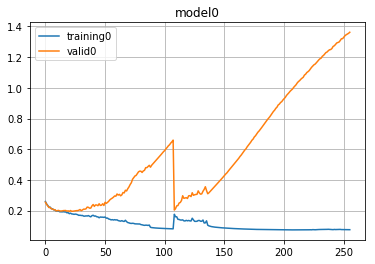

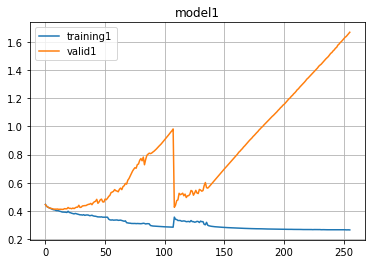

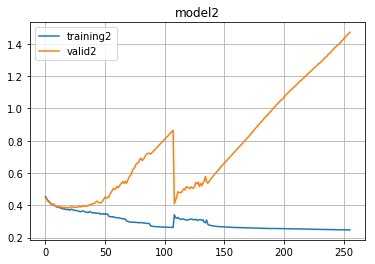

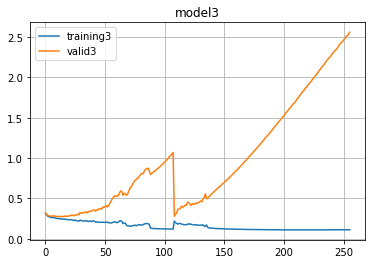

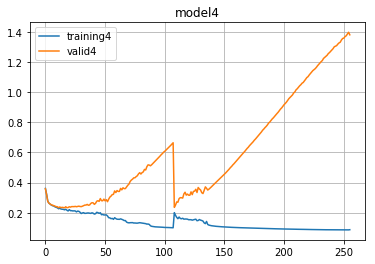

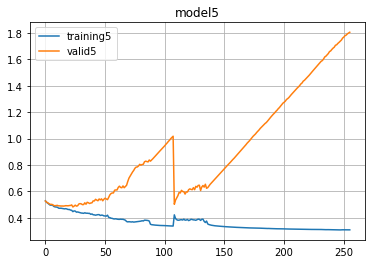

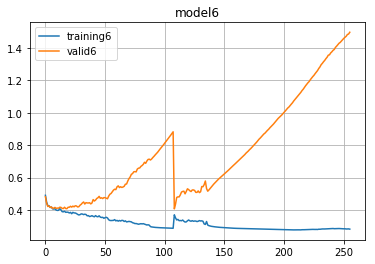

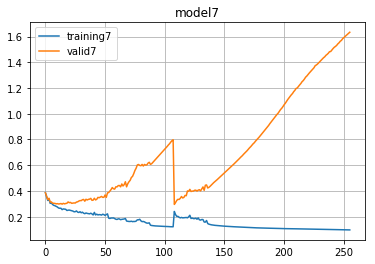

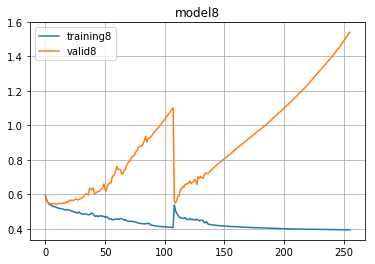

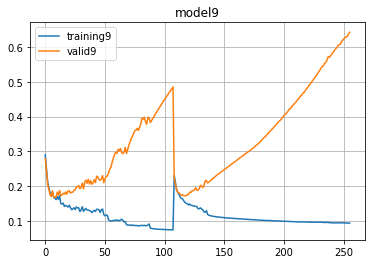

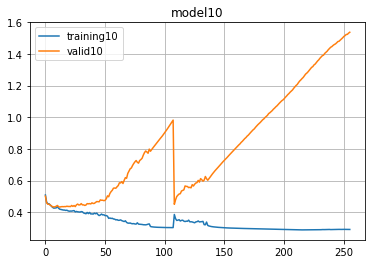

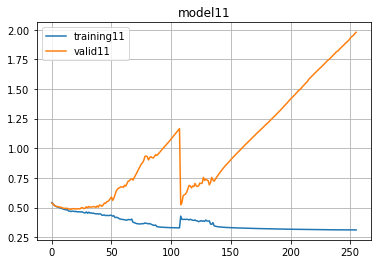

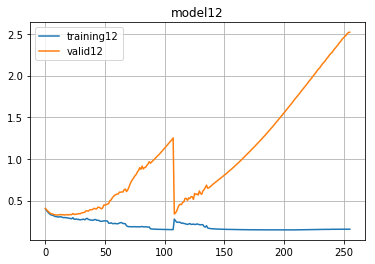

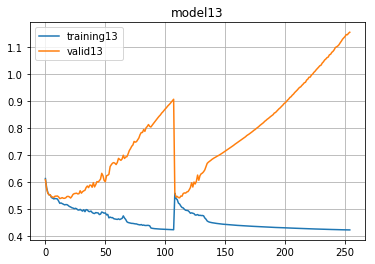

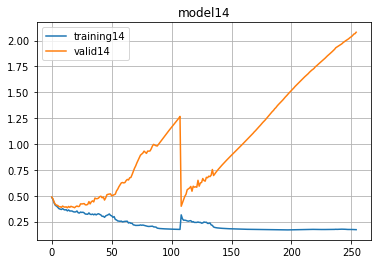

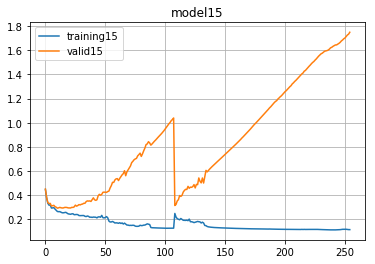

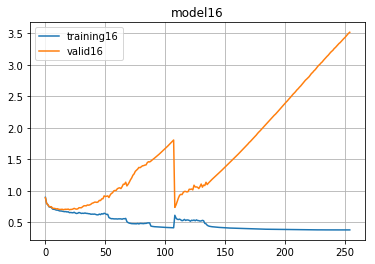

In [121]:
for idx in range(len(model_lst[cv_num])) :
    plt.plot(tl_ta_vl_va_lst[cv_num][idx][0], label='training'+str(idx))
    plt.plot(tl_ta_vl_va_lst[cv_num][idx][2], label='valid'+str(idx))
    plt.title("model"+str(idx))
    plt.grid("on")
    plt.legend()
    plt.show()

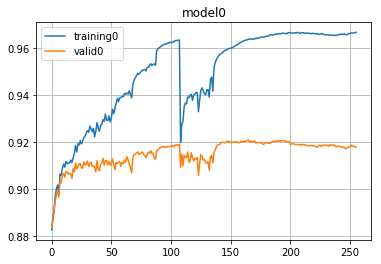

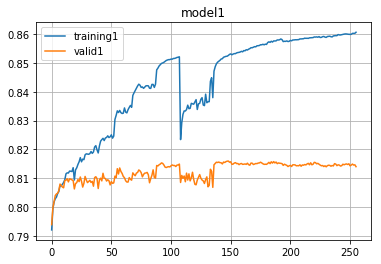

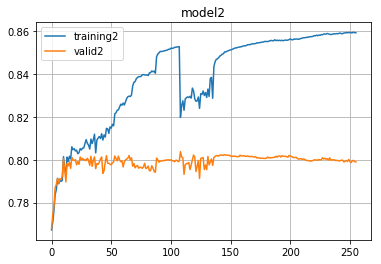

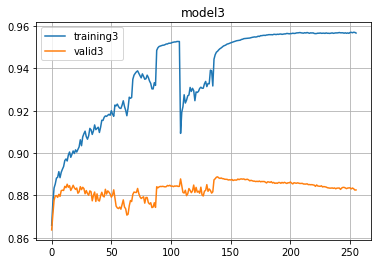

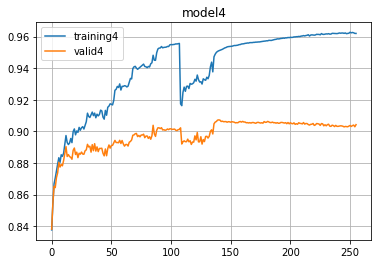

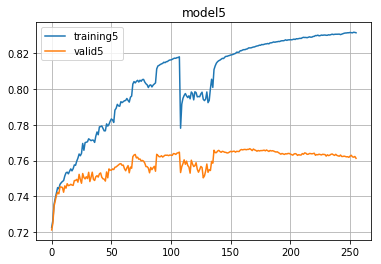

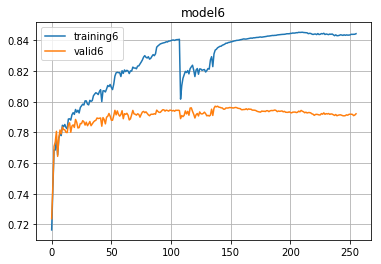

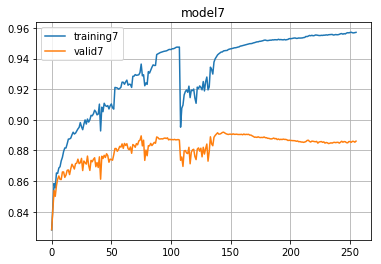

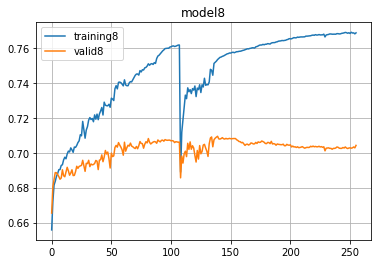

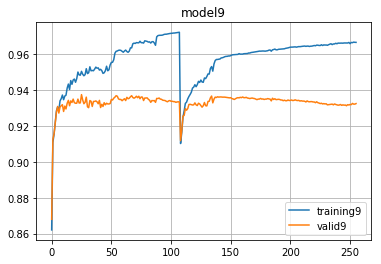

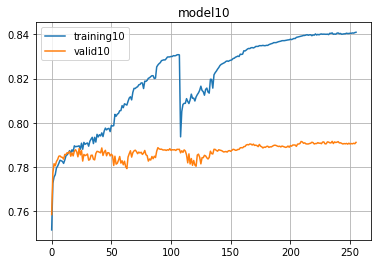

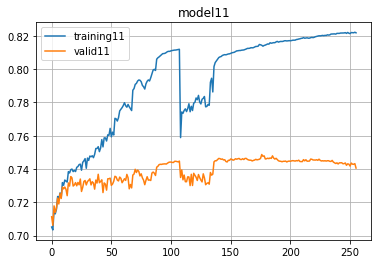

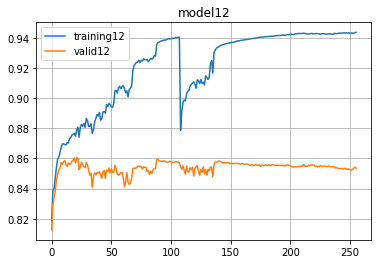

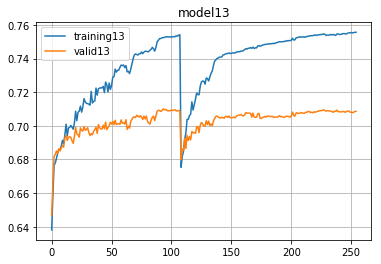

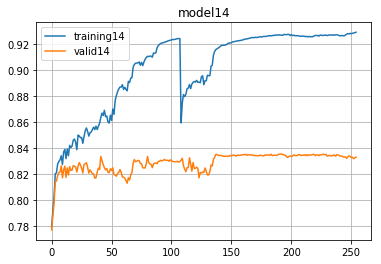

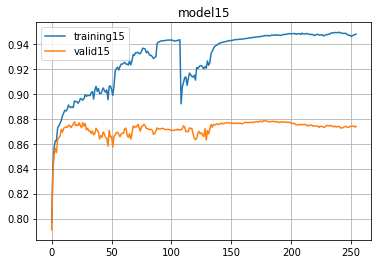

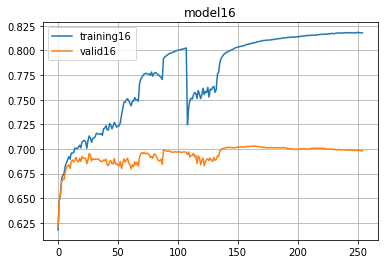

In [122]:
for idx in range(len(model_lst[cv_num])) :
    plt.plot(tl_ta_vl_va_lst[cv_num][idx][1], label='training'+str(idx))
    plt.plot(tl_ta_vl_va_lst[cv_num][idx][3], label='valid'+str(idx))
    plt.title("model"+str(idx))
    plt.grid("on")
    plt.legend()
    plt.show()

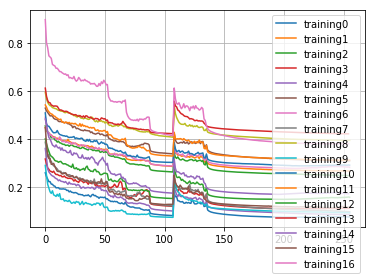

In [123]:
for idx in range(len(model_lst[cv_num])) :
    plt.plot(tl_ta_vl_va_lst[cv_num][idx][0], label='training'+str(idx))
    
plt.grid("on")
plt.legend()
plt.show()

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 12, in zmq.backend.cython.checkrc._check_rc (zmq/backend/cython/message.c:4294)
KeyboardInterrupt


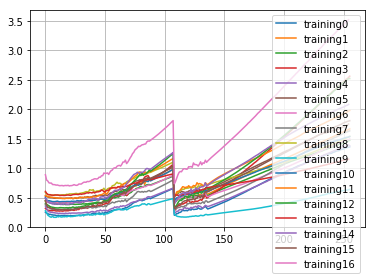

In [124]:
for idx in range(len(model_lst[cv_num])) :
    plt.plot(tl_ta_vl_va_lst[cv_num][idx][2], label='training'+str(idx))
    
plt.grid("on")
plt.legend()
plt.show()

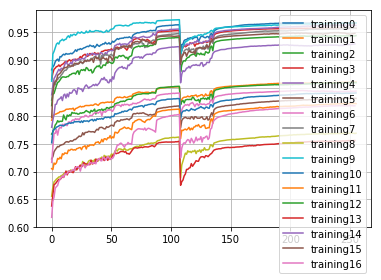

In [125]:
for idx in range(len(model_lst[cv_num])) :
    plt.plot(tl_ta_vl_va_lst[cv_num][idx][1], label='training'+str(idx))
    
plt.grid("on")
plt.legend()
plt.show()

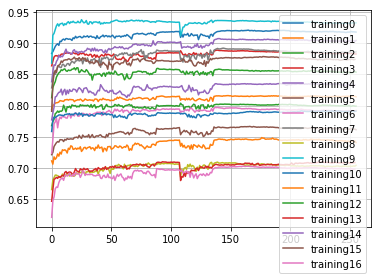

In [126]:
for idx in range(len(model_lst[cv_num])) :
    plt.plot(tl_ta_vl_va_lst[cv_num][idx][3], label='training'+str(idx))
    
plt.grid("on")
plt.legend()
plt.show()

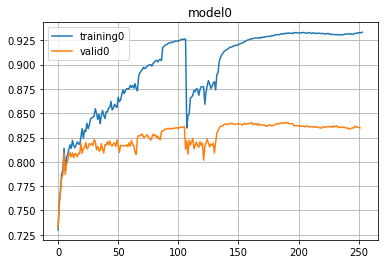

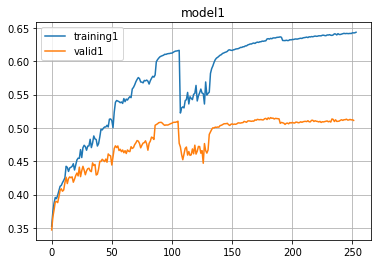

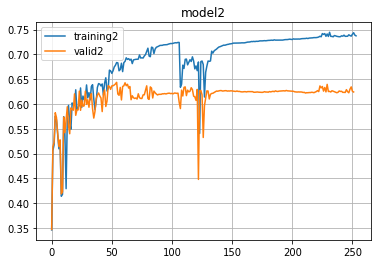

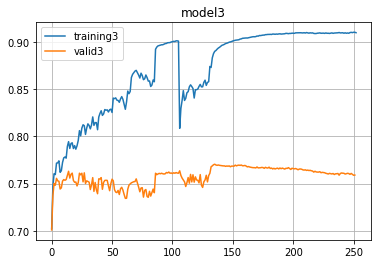

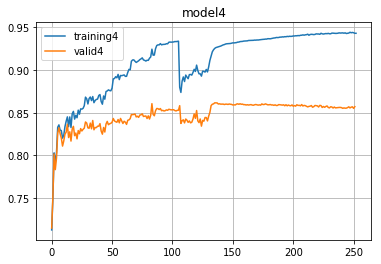

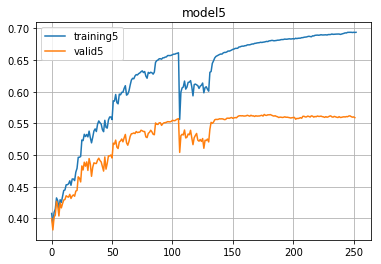

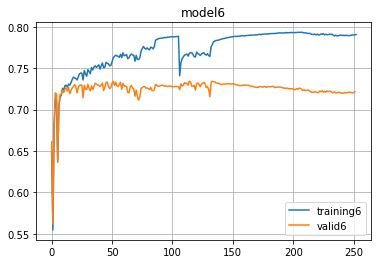

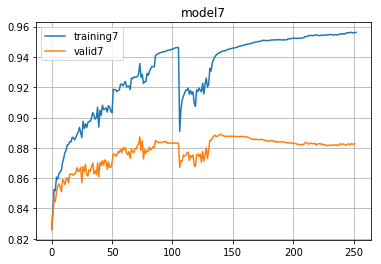

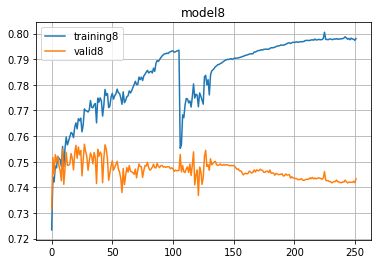

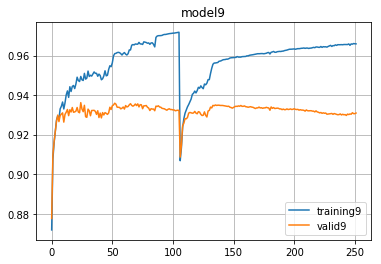

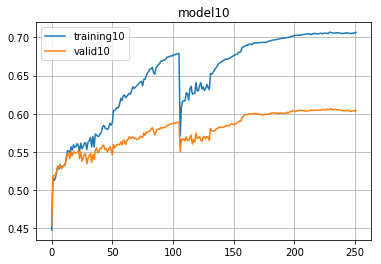

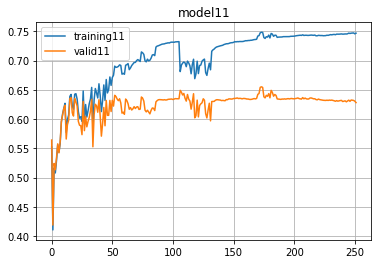

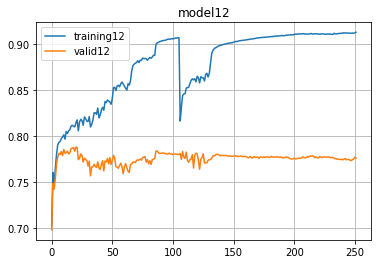

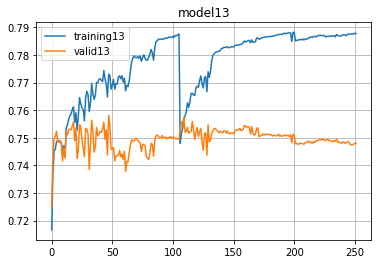

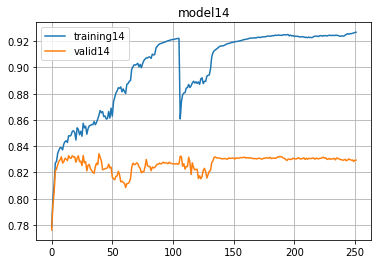

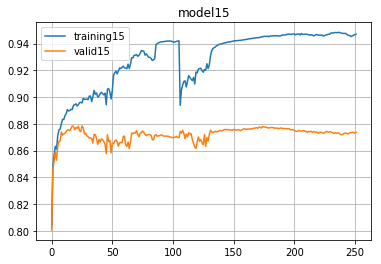

In [127]:
for idx in range(len(model_lst[cv_num])-1) :
    plt.plot(tl_ta_vl_va_lst[cv_num][idx][4], label='training'+str(idx))
    plt.plot(tl_ta_vl_va_lst[cv_num][idx][5], label='valid'+str(idx))
    plt.title("model"+str(idx))
    plt.grid("on")
    plt.legend()
    plt.show()

 <br></br><br></br><br></br>  

# Ensemble

In [185]:
def making_valid(cv, fold=5) :
    activity = cv.drop("label", axis=1)
    
    activity1 = activity[activity["wk"]==1].drop(["acc_id", "wk"], axis=1)
    activity2 = activity[activity["wk"]==2].drop(["acc_id", "wk"], axis=1)
    activity3 = activity[activity["wk"]==3].drop(["acc_id", "wk"], axis=1)
    activity4 = activity[activity["wk"]==4].drop(["acc_id", "wk"], axis=1)
    activity5 = activity[activity["wk"]==5].drop(["acc_id", "wk"], axis=1)
    activity6 = activity[activity["wk"]==6].drop(["acc_id", "wk"], axis=1)
    activity7 = activity[activity["wk"]==7].drop(["acc_id", "wk"], axis=1)
    activity8 = activity[activity["wk"]==8].drop(["acc_id", "wk"], axis=1)
    
    num_values = len(activity1.values[0])
    activity = np.concatenate([activity1.values.reshape([-1, 1, num_values]), activity2.values.reshape([-1, 1, num_values]), 
                               activity3.values.reshape([-1, 1, num_values]), activity4.values.reshape([-1, 1, num_values]),
                               activity5.values.reshape([-1, 1, num_values]), activity6.values.reshape([-1, 1, num_values]),
                               activity7.values.reshape([-1, 1, num_values]), activity8.values.reshape([-1, 1, num_values])], axis=1)
    
    return activity

In [186]:
def making_ensemble(cv, pred, pred_id, fold=5) :
    activity = cv.drop("label", axis=1)
    label = pd.concat([pd.DataFrame(sorted(list(set(pred_id.acc_id.tolist()))), columns = ["acc_id"]), pred], axis=1)

    activity = pd.merge(activity, label, how='left', on='acc_id')
    activity = activity[activity["label"] < 0.7].drop("label", axis=1)
    acc_id = activity[["acc_id"]]
    
    activity1 = activity[activity["wk"]==1].drop(["acc_id", "wk"], axis=1)
    activity2 = activity[activity["wk"]==2].drop(["acc_id", "wk"], axis=1)
    activity3 = activity[activity["wk"]==3].drop(["acc_id", "wk"], axis=1)
    activity4 = activity[activity["wk"]==4].drop(["acc_id", "wk"], axis=1)
    activity5 = activity[activity["wk"]==5].drop(["acc_id", "wk"], axis=1)
    activity6 = activity[activity["wk"]==6].drop(["acc_id", "wk"], axis=1)
    activity7 = activity[activity["wk"]==7].drop(["acc_id", "wk"], axis=1)
    activity8 = activity[activity["wk"]==8].drop(["acc_id", "wk"], axis=1)
    
    num_values = len(activity1.values[0])
    activity = np.concatenate([activity1.values.reshape([-1, 1, num_values]), activity2.values.reshape([-1, 1, num_values]), 
                               activity3.values.reshape([-1, 1, num_values]), activity4.values.reshape([-1, 1, num_values]),
                               activity5.values.reshape([-1, 1, num_values]), activity6.values.reshape([-1, 1, num_values]),
                               activity7.values.reshape([-1, 1, num_values]), activity8.values.reshape([-1, 1, num_values])], axis=1)

    return activity, acc_id

In [132]:
def making_df(pred, pred_id) :
    label = pd.concat([pd.DataFrame(sorted(list(set(pred_id.acc_id.tolist()))), columns = ["acc_id"]), pred], axis=1)

    return label

In [200]:
cv_data = get_data_cv("OnlyExpanded.csv")

In [201]:
result_df_lst = []

for cv_num in range(1) :
    print("")
    
    if cv_num == 0 :
        valid_num = 4
    elif cv_num == 1 :
        valid_num = 3
    elif cv_num == 2 :
        valid_num = 2
    elif cv_num == 3 :
        valid_num = 1
    elif cv_num == 4 :
        valid_num = 0
        
    
    # 초기 분기
    valid_cv_lst = making_valid(cv_data[valid_num])
    valid_cv_acc_id = cv_data[valid_num][["acc_id"]]
    
    result0 = [model_lst[cv_num][0].sess.run(model_lst[cv_num][0].softmax, 
                                             feed_dict = {model_lst[cv_num][0].X : valid_cv_lst, model_lst[cv_num][0].training :False})][0][:,1]
    result0 = list(result0)
    
    result1 = [model_lst[cv_num][1].sess.run(model_lst[cv_num][1].softmax, 
                                             feed_dict = {model_lst[cv_num][1].X : valid_cv_lst, model_lst[cv_num][1].training :False})][0][:,1]
    result1 = list(result1)
    
    result2 = [model_lst[cv_num][2].sess.run(model_lst[cv_num][2].softmax, 
                                             feed_dict = {model_lst[cv_num][2].X : valid_cv_lst, model_lst[cv_num][2].training :False})][0][:,1]
    result2 = list(result2)
    
    result3 = [model_lst[cv_num][3].sess.run(model_lst[cv_num][3].softmax, 
                                             feed_dict = {model_lst[cv_num][3].X : valid_cv_lst, model_lst[cv_num][3].training :False})][0][:,1]
    result3 = list(result3)
    
    result_df0 = pd.DataFrame(result0).rename(columns = {0 : "label"})
    result_df1 = pd.DataFrame(result1).rename(columns = {0 : "label"})
    result_df2 = pd.DataFrame(result2).rename(columns = {0 : "label"})
    result_df3 = pd.DataFrame(result3).rename(columns = {0 : "label"})

    
    # retain 분기
    valid_cv_lst3, valid_cv_acc_id3 = making_ensemble(cv_data[valid_num], result_df3, valid_cv_acc_id)

    result4 = [model_lst[cv_num][4].sess.run(model_lst[cv_num][4].softmax, 
                                             feed_dict = {model_lst[cv_num][4].X : valid_cv_lst3, 
                                                          model_lst[cv_num][4].training :False})][0][:,1]
    result4 = list(result4)

    result5 = [model_lst[cv_num][5].sess.run(model_lst[cv_num][5].softmax, 
                                             feed_dict = {model_lst[cv_num][5].X : valid_cv_lst3, model_lst[cv_num][5].training :False})][0][:,1]
    result5 = list(result5)
    
    result6 = [model_lst[cv_num][6].sess.run(model_lst[cv_num][6].softmax, 
                                             feed_dict = {model_lst[cv_num][6].X : valid_cv_lst3, model_lst[cv_num][6].training :False})][0][:,1]
    result6 = list(result6)
    
    result_df4 = pd.DataFrame(result4).rename(columns = {0 : "label"})
    result_df5 = pd.DataFrame(result5).rename(columns = {0 : "label"})
    result_df6 = pd.DataFrame(result6).rename(columns = {0 : "label"})
    
    valid_cv_lst6, valid_cv_acc_id6 = making_ensemble(cv_data[valid_num], result_df6, valid_cv_acc_id3)
    valid_cv_lst4, valid_cv_acc_id4 = making_ensemble(cv_data[valid_num], result_df4, valid_cv_acc_id3)
    valid_cv_lst5, valid_cv_acc_id5 = making_ensemble(cv_data[valid_num], result_df5, valid_cv_acc_id3)
    
    result7 = [model_lst[cv_num][7].sess.run(model_lst[cv_num][7].softmax, 
                                             feed_dict = {model_lst[cv_num][7].X : valid_cv_lst6, model_lst[cv_num][7].training :False})][0][:,1]
    result7 = list(result7)
    
    result8 = [model_lst[cv_num][8].sess.run(model_lst[cv_num][8].softmax, 
                                             feed_dict = {model_lst[cv_num][8].X : valid_cv_lst4, model_lst[cv_num][8].training :False})][0][:,1]
    result8 = list(result8)
    
    result9 = [model_lst[cv_num][9].sess.run(model_lst[cv_num][9].softmax, 
                                             feed_dict = {model_lst[cv_num][9].X : valid_cv_lst5, model_lst[cv_num][9].training :False})][0][:,1]
    result9 = list(result9)
    
    result_df7 = pd.DataFrame(result7).rename(columns = {0 : "label"})
    result_df8 = pd.DataFrame(result8).rename(columns = {0 : "label"})
    result_df9 = pd.DataFrame(result9).rename(columns = {0 : "label"})
    
    
    # week 분기
    valid_cv_lst0, valid_cv_acc_id0 = making_ensemble(cv_data[valid_num], result_df0, valid_cv_acc_id)
    
    result10 = [model_lst[cv_num][10].sess.run(model_lst[cv_num][10].softmax, 
                                             feed_dict = {model_lst[cv_num][10].X : valid_cv_lst0, model_lst[cv_num][10].training :False})][0][:,1]
    result10 = list(result10)
    
    result11 = [model_lst[cv_num][11].sess.run(model_lst[cv_num][11].softmax, 
                                             feed_dict = {model_lst[cv_num][11].X : valid_cv_lst0, model_lst[cv_num][11].training :False})][0][:,1]
    result11 = list(result11)
    
    result12 = [model_lst[cv_num][12].sess.run(model_lst[cv_num][12].softmax, 
                                             feed_dict = {model_lst[cv_num][12].X : valid_cv_lst0, model_lst[cv_num][12].training :False})][0][:,1]
    result12 = list(result12)
    
    result_df10 = pd.DataFrame(result10).rename(columns = {0 : "label"})
    result_df11 = pd.DataFrame(result11).rename(columns = {0 : "label"})
    result_df12 = pd.DataFrame(result12).rename(columns = {0 : "label"})
    
    valid_cv_lst12, valid_cv_acc_id12 = making_ensemble(cv_data[valid_num], result_df12, valid_cv_acc_id0)
    valid_cv_lst10, valid_cv_acc_id10 = making_ensemble(cv_data[valid_num], result_df10, valid_cv_acc_id0)
    valid_cv_lst11, valid_cv_acc_id11 = making_ensemble(cv_data[valid_num], result_df11, valid_cv_acc_id0)
    
    result13 = [model_lst[cv_num][13].sess.run(model_lst[cv_num][13].softmax, 
                                             feed_dict = {model_lst[cv_num][13].X : valid_cv_lst12, model_lst[cv_num][13].training :False})][0][:,1]
    result13 = list(result13)
    
    result14 = [model_lst[cv_num][14].sess.run(model_lst[cv_num][14].softmax, 
                                             feed_dict = {model_lst[cv_num][14].X : valid_cv_lst10, model_lst[cv_num][14].training :False})][0][:,1]
    result14 = list( result14)
    
    result15 = [model_lst[cv_num][15].sess.run(model_lst[cv_num][15].softmax, 
                                             feed_dict = {model_lst[cv_num][15].X : valid_cv_lst11, model_lst[cv_num][15].training :False})][0][:,1]
    result15 = list(result15)
    
    result_df13 = pd.DataFrame(result13).rename(columns = {0 : "label"})
    result_df14 = pd.DataFrame(result14).rename(columns = {0 : "label"})
    result_df15 = pd.DataFrame(result15).rename(columns = {0 : "label"})
    
    
    # 모든 label 예측
    result16 = [model_lst[cv_num][16].sess.run(model_lst[cv_num][16].softmax, 
                                             feed_dict = {model_lst[cv_num][16].X : valid_cv_lst, model_lst[cv_num][16].training :False})][0][:,:]
    result16 = list(result16)
    
    result_df16 = pd.DataFrame(result16).rename(columns = {0 : "total_week", 1: "total_month", 2:"total_2month", 3:"total_retained"})
    
    result_stack_df = pd.concat([making_df(result_df0, valid_cv_acc_id).set_index("acc_id").rename(columns={"label" : "week-tree"}), 
                                 making_df(result_df1, valid_cv_acc_id).set_index("acc_id").rename(columns={"label" : "month-tree"}), 
                                 making_df(result_df2, valid_cv_acc_id).set_index("acc_id").rename(columns={"label" : "2month-tree"}), 
                                 making_df(result_df3, valid_cv_acc_id).set_index("acc_id").rename(columns={"label" : "retained-tree"}), 
                                 making_df(result_df4, valid_cv_acc_id3).set_index("acc_id").rename(columns={"label" : "retained-week-tree"}), 
                                 making_df(result_df5, valid_cv_acc_id3).set_index("acc_id").rename(columns={"label" : "retained-month-tree"}), 
                                 making_df(result_df6, valid_cv_acc_id3).set_index("acc_id").rename(columns={"label" : "retained-2month-tree"}), 
                                 making_df(result_df7, valid_cv_acc_id6).set_index("acc_id").rename(columns={"label" : "retained-2month-week_month-tree"}), 
                                 making_df(result_df8, valid_cv_acc_id4).set_index("acc_id").rename(columns={"label" : "retained-week-month_2month-tree"}),
                                 making_df(result_df9, valid_cv_acc_id5).set_index("acc_id").rename(columns={"label" : "retained-month-week_2month-tree"}),
                                 making_df(result_df10, valid_cv_acc_id0).set_index("acc_id").rename(columns={"label" : "week-month-tree"}), 
                                 making_df(result_df11, valid_cv_acc_id0).set_index("acc_id").rename(columns={"label" : "week-2month-tree"}), 
                                 making_df(result_df12, valid_cv_acc_id0).set_index("acc_id").rename(columns={"label" : "week-retained-tree"}), 
                                 making_df(result_df13, valid_cv_acc_id12).set_index("acc_id").rename(columns={"label" : "week-retained-month_2month-tree"}), 
                                 making_df(result_df14, valid_cv_acc_id10).set_index("acc_id").rename(columns={"label" : "week-month-2month_retained-tree"}),
                                 making_df(result_df15, valid_cv_acc_id11).set_index("acc_id").rename(columns={"label" : "week-2month-month_retained-tree"}),
                                 making_df(result_df16, valid_cv_acc_id).set_index("acc_id").rename(columns={"label" : "total"})], axis=1)
    
    result_df_lst.append(result_stack_df)

In [202]:
valid_label_for_cv4 = pd.DataFrame(np.argmax(total_label16[4],axis=1)).rename(columns = {0 : "label"})

print(len(valid_label_for_cv4))
valid_label_for_cv4.head()

20000


,label
0,1
1,3
2,0
3,2
4,3


In [203]:
result_stack_df_label = pd.concat([result_stack_df.reset_index(), valid_label_for_cv4], axis=1).rename(columns = {"index" : "acc_id"}).set_index("acc_id")

print(len(result_stack_df_label))
result_stack_df_label.head()

20000


,week-tree,month-tree,2month-tree,retained-tree,retained-week-tree,retained-month-tree,retained-2month-tree,retained-2month-week_month-tree,retained-week-month_2month-tree,retained-month-week_2month-tree,week-month-tree,week-2month-tree,week-retained-tree,week-retained-month_2month-tree,week-month-2month_retained-tree,week-2month-month_retained-tree,total_week,total_month,total_2month,total_retained,label
acc_id,,,,,,,,,,,,,,,,,,,,,
cce8cf742d779df73ac7d13effb2fe76cf06cc8c4fb6ee51b006579dfdc53b6b,1.509710e-02,0.889619,8.607723e-03,0.020867,0.058788,0.942421,0.000255,0.930623,1.152129e-07,NaN,9.965061e-01,0.003331,0.021363,0.000002,NaN,0.051316,1.031506e-01,0.879038,4.910580e-03,0.012901,1
cce8f7a34235ec6c08b13e41afcafb667c8a0f63dc429f8d76f88362ec7fcb39,0.000000e+00,0.000000,1.066952e-08,0.999995,NaN,NaN,NaN,NaN,NaN,NaN,2.101917e-18,0.000000,1.000000,NaN,1.000000,1.000000,1.324211e-25,0.000005,6.628296e-17,0.999995,3
cce9bf6a13008fc11ecdc2c855ff844e869eceeda22ebcde89b7d1064e5b5eb5,5.917798e-01,0.022067,5.577732e-02,0.009783,0.683343,0.084129,0.008913,0.092162,5.637858e-01,0.051236,5.088669e-01,0.077653,0.075693,0.202722,0.108016,0.149553,5.826866e-01,0.232607,8.504402e-02,0.099663,0
ccebea3ff3a74ae9c9ce4a15e2f80f8a336ae1a0ba3e53ea2b851d889aa27f20,1.536979e-35,0.000056,3.578402e-01,0.883604,NaN,NaN,NaN,NaN,NaN,NaN,1.311273e-07,0.459865,0.579961,0.766740,0.934080,0.999996,2.790499e-07,0.018602,3.068831e-01,0.674514,2
ccec4f896d13bdcbf2279760bda2bbd7b4bdac229761f9d988cfbc34c342906e,5.100701e-25,0.013531,2.349116e-05,0.928284,NaN,NaN,NaN,NaN,NaN,NaN,6.560043e-03,0.000002,0.904302,NaN,0.999896,0.998422,1.475391e-11,0.001142,8.480202e-03,0.990378,3


In [204]:
result_stack_df_label.to_csv("final_result/valid_250_epoch.csv")

<br></br><br></br><br></br>

# Test

In [150]:
def get_data_cv2(csv, fold=1) :
    activity= pd.read_csv(csv).drop("Unnamed: 0", axis=1)
    activity = activity[activity["label"] == "empty"]
    
    activity = activity.sort_values(["acc_id","wk"])[['acc_id', 'wk', 'cnt_clear_bam', 'cnt_clear_inzone_light','cnt_clear_inzone_normal', 
                                                      'cnt_clear_inzone_skilled', 'cnt_clear_inzone_solo', 'cnt_clear_raid', 'cnt_clear_raid_light',
                                                      'cnt_dt', 'cnt_enter_bam', 'cnt_enter_inzone_light', 'cnt_enter_inzone_normal', 
                                                      'cnt_enter_inzone_skilled', 'cnt_enter_inzone_solo', 'cnt_enter_raid', 'cnt_enter_raid_light',
                                                      'cnt_use_buffitem', 'district_chat', 'duel_cnt', 'duel_win', 'faction_chat', 'game_combat_time', 
                                                      'gathering_cnt', 'get_money','guild_chat', 'item_hongmun', 'making_cnt', 'normal_chat', 
                                                      'npc_exp', 'npc_hongmun', 'party_chat', 'partybattle_cnt', 'partybattle_win', 'play_time', 
                                                      'quest_exp', 'quest_hongmun', 'whisper_chat','first_week', 'payment_amount', 'label']]
    
    activity_lst = []
    length = len(activity)//fold
    idx = 0
    for _ in range(fold) :
        activity_lst.append(activity[idx:idx+length])
        idx += length
        
    return activity_lst

In [151]:
def making_test(cv, fold=5) :
    activity = cv.drop("label", axis=1)
    
    activity1 = activity[activity["wk"]==1].drop(["acc_id", "wk"], axis=1)
    activity2 = activity[activity["wk"]==2].drop(["acc_id", "wk"], axis=1)
    activity3 = activity[activity["wk"]==3].drop(["acc_id", "wk"], axis=1)
    activity4 = activity[activity["wk"]==4].drop(["acc_id", "wk"], axis=1)
    activity5 = activity[activity["wk"]==5].drop(["acc_id", "wk"], axis=1)
    activity6 = activity[activity["wk"]==6].drop(["acc_id", "wk"], axis=1)
    activity7 = activity[activity["wk"]==7].drop(["acc_id", "wk"], axis=1)
    activity8 = activity[activity["wk"]==8].drop(["acc_id", "wk"], axis=1)
    
    num_values = len(activity1.values[0])
    activity = np.concatenate([activity1.values.reshape([-1, 1, num_values]), activity2.values.reshape([-1, 1, num_values]), 
                               activity3.values.reshape([-1, 1, num_values]), activity4.values.reshape([-1, 1, num_values]),
                               activity5.values.reshape([-1, 1, num_values]), activity6.values.reshape([-1, 1, num_values]),
                               activity7.values.reshape([-1, 1, num_values]), activity8.values.reshape([-1, 1, num_values])], axis=1)
    
    return activity

In [194]:
test = get_data_cv2("OnlyExpanded.csv")
cv_data = test

In [195]:
result_df_lst = []

for cv_num in range(1) :
    print("")
    
    if cv_num == 0 :
        valid_num = 4
    elif cv_num == 1 :
        valid_num = 3
    elif cv_num == 2 :
        valid_num = 2
    elif cv_num == 3 :
        valid_num = 1
    elif cv_num == 4 :
        valid_num = 0
    valid_num = 0
    
    # 초기 분기
    valid_cv_lst = making_valid(cv_data[valid_num])
    valid_cv_acc_id = cv_data[valid_num][["acc_id"]]
    
    result0 = [model_lst[cv_num][0].sess.run(model_lst[cv_num][0].softmax, 
                                             feed_dict = {model_lst[cv_num][0].X : valid_cv_lst, model_lst[cv_num][0].training :False})][0][:,1]
    result0 = list(result0)
    
    result1 = [model_lst[cv_num][1].sess.run(model_lst[cv_num][1].softmax, 
                                             feed_dict = {model_lst[cv_num][1].X : valid_cv_lst, model_lst[cv_num][1].training :False})][0][:,1]
    result1 = list(result1)
    
    result2 = [model_lst[cv_num][2].sess.run(model_lst[cv_num][2].softmax, 
                                             feed_dict = {model_lst[cv_num][2].X : valid_cv_lst, model_lst[cv_num][2].training :False})][0][:,1]
    result2 = list(result2)
    
    result3 = [model_lst[cv_num][3].sess.run(model_lst[cv_num][3].softmax, 
                                             feed_dict = {model_lst[cv_num][3].X : valid_cv_lst, model_lst[cv_num][3].training :False})][0][:,1]
    result3 = list(result3)
    
    result_df0 = pd.DataFrame(result0).rename(columns = {0 : "label"})
    result_df1 = pd.DataFrame(result1).rename(columns = {0 : "label"})
    result_df2 = pd.DataFrame(result2).rename(columns = {0 : "label"})
    result_df3 = pd.DataFrame(result3).rename(columns = {0 : "label"})

    
    # retain 분기
    valid_cv_lst3, valid_cv_acc_id3 = making_ensemble(cv_data[valid_num], result_df3, valid_cv_acc_id)

    result4 = [model_lst[cv_num][4].sess.run(model_lst[cv_num][4].softmax, 
                                             feed_dict = {model_lst[cv_num][4].X : valid_cv_lst3, 
                                                          model_lst[cv_num][4].training :False})][0][:,1]
    result4 = list(result4)

    result5 = [model_lst[cv_num][5].sess.run(model_lst[cv_num][5].softmax, 
                                             feed_dict = {model_lst[cv_num][5].X : valid_cv_lst3, model_lst[cv_num][5].training :False})][0][:,1]
    result5 = list(result5)
    
    result6 = [model_lst[cv_num][6].sess.run(model_lst[cv_num][6].softmax, 
                                             feed_dict = {model_lst[cv_num][6].X : valid_cv_lst3, model_lst[cv_num][6].training :False})][0][:,1]
    result6 = list(result6)
    
    result_df4 = pd.DataFrame(result4).rename(columns = {0 : "label"})
    result_df5 = pd.DataFrame(result5).rename(columns = {0 : "label"})
    result_df6 = pd.DataFrame(result6).rename(columns = {0 : "label"})
    
    valid_cv_lst6, valid_cv_acc_id6 = making_ensemble(cv_data[valid_num], result_df6, valid_cv_acc_id3)
    valid_cv_lst4, valid_cv_acc_id4 = making_ensemble(cv_data[valid_num], result_df4, valid_cv_acc_id3)
    valid_cv_lst5, valid_cv_acc_id5 = making_ensemble(cv_data[valid_num], result_df5, valid_cv_acc_id3)
    
    result7 = [model_lst[cv_num][7].sess.run(model_lst[cv_num][7].softmax, 
                                             feed_dict = {model_lst[cv_num][7].X : valid_cv_lst6, model_lst[cv_num][7].training :False})][0][:,1]
    result7 = list(result7)
    
    result8 = [model_lst[cv_num][8].sess.run(model_lst[cv_num][8].softmax, 
                                             feed_dict = {model_lst[cv_num][8].X : valid_cv_lst4, model_lst[cv_num][8].training :False})][0][:,1]
    result8 = list(result8)
    
    result9 = [model_lst[cv_num][9].sess.run(model_lst[cv_num][9].softmax, 
                                             feed_dict = {model_lst[cv_num][9].X : valid_cv_lst5, model_lst[cv_num][9].training :False})][0][:,1]
    result9 = list(result9)
    
    result_df7 = pd.DataFrame(result7).rename(columns = {0 : "label"})
    result_df8 = pd.DataFrame(result8).rename(columns = {0 : "label"})
    result_df9 = pd.DataFrame(result9).rename(columns = {0 : "label"})
    
    
    # week 분기
    valid_cv_lst0, valid_cv_acc_id0 = making_ensemble(cv_data[valid_num], result_df0, valid_cv_acc_id)
    
    result10 = [model_lst[cv_num][10].sess.run(model_lst[cv_num][10].softmax, 
                                             feed_dict = {model_lst[cv_num][10].X : valid_cv_lst0, model_lst[cv_num][10].training :False})][0][:,1]
    result10 = list(result10)
    
    result11 = [model_lst[cv_num][11].sess.run(model_lst[cv_num][11].softmax, 
                                             feed_dict = {model_lst[cv_num][11].X : valid_cv_lst0, model_lst[cv_num][11].training :False})][0][:,1]
    result11 = list(result11)
    
    result12 = [model_lst[cv_num][12].sess.run(model_lst[cv_num][12].softmax, 
                                             feed_dict = {model_lst[cv_num][12].X : valid_cv_lst0, model_lst[cv_num][12].training :False})][0][:,1]
    result12 = list(result12)
    
    result_df10 = pd.DataFrame(result10).rename(columns = {0 : "label"})
    result_df11 = pd.DataFrame(result11).rename(columns = {0 : "label"})
    result_df12 = pd.DataFrame(result12).rename(columns = {0 : "label"})
    
    valid_cv_lst12, valid_cv_acc_id12 = making_ensemble(cv_data[valid_num], result_df12, valid_cv_acc_id0)
    valid_cv_lst10, valid_cv_acc_id10 = making_ensemble(cv_data[valid_num], result_df10, valid_cv_acc_id0)
    valid_cv_lst11, valid_cv_acc_id11 = making_ensemble(cv_data[valid_num], result_df11, valid_cv_acc_id0)
    
    result13 = [model_lst[cv_num][13].sess.run(model_lst[cv_num][13].softmax, 
                                             feed_dict = {model_lst[cv_num][13].X : valid_cv_lst12, model_lst[cv_num][13].training :False})][0][:,1]
    result13 = list(result13)
    
    result14 = [model_lst[cv_num][14].sess.run(model_lst[cv_num][14].softmax, 
                                             feed_dict = {model_lst[cv_num][14].X : valid_cv_lst10, model_lst[cv_num][14].training :False})][0][:,1]
    result14 = list( result14)
    
    result15 = [model_lst[cv_num][15].sess.run(model_lst[cv_num][15].softmax, 
                                             feed_dict = {model_lst[cv_num][15].X : valid_cv_lst11, model_lst[cv_num][15].training :False})][0][:,1]
    result15 = list(result15)
    
    result_df13 = pd.DataFrame(result13).rename(columns = {0 : "label"})
    result_df14 = pd.DataFrame(result14).rename(columns = {0 : "label"})
    result_df15 = pd.DataFrame(result15).rename(columns = {0 : "label"})
    
    
    # 모든 label 예측
    result16 = [model_lst[cv_num][16].sess.run(model_lst[cv_num][16].softmax, 
                                             feed_dict = {model_lst[cv_num][16].X : valid_cv_lst, model_lst[cv_num][16].training :False})][0][:,:]
    result16 = list(result16)
    
    result_df16 = pd.DataFrame(result16).rename(columns = {0 : "total_week", 1: "total_month", 2:"total_2month", 3:"total_retained"})
    
    result_stack_df = pd.concat([making_df(result_df0, valid_cv_acc_id).set_index("acc_id").rename(columns={"label" : "week-tree"}), 
                                 making_df(result_df1, valid_cv_acc_id).set_index("acc_id").rename(columns={"label" : "month-tree"}), 
                                 making_df(result_df2, valid_cv_acc_id).set_index("acc_id").rename(columns={"label" : "2month-tree"}), 
                                 making_df(result_df3, valid_cv_acc_id).set_index("acc_id").rename(columns={"label" : "retained-tree"}), 
                                 making_df(result_df4, valid_cv_acc_id3).set_index("acc_id").rename(columns={"label" : "retained-week-tree"}), 
                                 making_df(result_df5, valid_cv_acc_id3).set_index("acc_id").rename(columns={"label" : "retained-month-tree"}), 
                                 making_df(result_df6, valid_cv_acc_id3).set_index("acc_id").rename(columns={"label" : "retained-2month-tree"}), 
                                 making_df(result_df7, valid_cv_acc_id6).set_index("acc_id").rename(columns={"label" : "retained-2month-week_month-tree"}), 
                                 making_df(result_df8, valid_cv_acc_id4).set_index("acc_id").rename(columns={"label" : "retained-week-month_2month-tree"}),
                                 making_df(result_df9, valid_cv_acc_id5).set_index("acc_id").rename(columns={"label" : "retained-month-week_2month-tree"}),
                                 making_df(result_df10, valid_cv_acc_id0).set_index("acc_id").rename(columns={"label" : "week-month-tree"}), 
                                 making_df(result_df11, valid_cv_acc_id0).set_index("acc_id").rename(columns={"label" : "week-2month-tree"}), 
                                 making_df(result_df12, valid_cv_acc_id0).set_index("acc_id").rename(columns={"label" : "week-retained-tree"}), 
                                 making_df(result_df13, valid_cv_acc_id12).set_index("acc_id").rename(columns={"label" : "week-retained-month_2month-tree"}), 
                                 making_df(result_df14, valid_cv_acc_id10).set_index("acc_id").rename(columns={"label" : "week-month-2month_retained-tree"}),
                                 making_df(result_df15, valid_cv_acc_id11).set_index("acc_id").rename(columns={"label" : "week-2month-month_retained-tree"}),
                                 making_df(result_df16, valid_cv_acc_id).set_index("acc_id").rename(columns={"label" : "total"})], axis=1)
    
    result_df_lst.append(result_stack_df)

In [196]:
result_stack_df.head()

,week-tree,month-tree,2month-tree,retained-tree,retained-week-tree,retained-month-tree,retained-2month-tree,retained-2month-week_month-tree,retained-week-month_2month-tree,retained-month-week_2month-tree,week-month-tree,week-2month-tree,week-retained-tree,week-retained-month_2month-tree,week-month-2month_retained-tree,week-2month-month_retained-tree,total_week,total_month,total_2month,total_retained
0002a56a036206aea3a6c6ebc985df4a2d1987b562e7f027e65003ba34491a9c,1.282105e-18,0.287728,7.576508e-01,0.000014,8.865926e-10,0.335192,0.289518,1.0,0.714316,0.999545,0.367014,0.343396,0.000370,0.778505,0.001731,0.010793,2.567430e-09,0.559539,0.438544,0.001917
0003bfdebe2b5d46217e8fa5ab0f33cf186fb558435f20206acba07ee5ec9f42,1.116987e-09,0.011985,5.927302e-12,0.001180,9.999859e-01,0.177245,0.998754,NaN,NaN,0.387136,0.728745,0.037440,0.955744,NaN,NaN,0.687728,6.980182e-03,0.970919,0.011460,0.010641
0008f5dce798aaac3f0b05f8a4269cf2052c9b8c5bd9114b54f3189fc10d62c9,3.464303e-08,0.219554,7.482451e-01,0.007912,2.858964e-05,0.281202,0.780203,NaN,0.730266,0.993167,0.261161,0.708864,0.006113,0.701051,0.007394,NaN,1.117059e-04,0.297933,0.692900,0.009055
000cacd86bddabebef813351455304df5493cd71a3d1d29f6a0511f658af6f7b,1.226835e-07,0.244845,7.135513e-01,0.051405,4.137673e-04,0.343690,0.738547,NaN,0.734775,0.997617,0.226864,0.735483,0.067612,0.768146,0.055259,NaN,1.238303e-03,0.233987,0.716136,0.048639
000ef0765596ac6a6a0a62654895e4673825b6102c7f411430f4c15faf1f8bb5,1.003806e-08,0.275327,3.624003e-01,0.614117,3.040017e-04,0.428519,0.391759,1.0,0.585624,0.999990,0.065011,0.333975,0.439294,0.506607,0.457827,0.540175,1.059176e-05,0.370309,0.351657,0.278023


In [197]:
result_stack_df.to_csv("final_result/test_250_epoch.csv")